In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [3]:
clinics_df = pd.read_csv('../data/datos_limpios_p1.csv', parse_dates=[2, 12, 13, 15, 17])
clinics_df['HourOfDay'] = clinics_df['TurnoInicioDateTime'].dt.hour
clinics_df.head(2)

C:\Users\cumpl\AppData\Local\Temp\ipykernel_13916\3127935692.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clinics_df = pd.read_csv('../data/datos_limpios_p1.csv', parse_dates=[2, 12, 13, 15, 17])
C:\Users\cumpl\AppData\Local\Temp\ipykernel_13916\3127935692.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clinics_df = pd.read_csv('../data/datos_limpios_p1.csv', parse_dates=[2, 12, 13, 15, 17])


Orden  Sucursal    FechaID  HoraLLegada   TurnoID Turno  \
0  424722  CULIACAN 2024-03-01            6  41691626  P001   
1  424738  CULIACAN 2024-03-01            6  41696473  N020   

            TurnoTipo TurnoHoraInicio TurnoHoraFin  TurnoMinutosEspera  \
0   Estudio Pendiente        06:32:32     06:34:58                2.43   
1  Solicitar Estudios        06:47:18     07:06:33               19.25   

   TAPRecepcionMinutos  TAPRecepcionCaja TurnoInicioDateTime  \
0                 0.58            1135.0 2024-03-01 06:32:32   
1                 4.42            1134.0 2024-03-01 06:47:18   

     TurnoFinDateTime TurnoGrupo WaitingTimeInLine  HourOfDay  \
0 2024-03-01 06:34:58          P   0 days 00:02:26          6   
1 2024-03-01 07:06:33          N   0 days 00:19:15          6   

            TimeInService  HasTimeInService  
0  0 days 00:00:34.800000                 1  
1  0 days 00:04:25.200000                 1

In [4]:
clinics_df['WaitingTimeInLine'] = pd.to_timedelta(clinics_df['WaitingTimeInLine'])

In [5]:
clinics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30578 entries, 0 to 30577
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Orden                30578 non-null  int64          
 1   Sucursal             30578 non-null  object         
 2   FechaID              30578 non-null  datetime64[ns] 
 3   HoraLLegada          30578 non-null  int64          
 4   TurnoID              30578 non-null  int64          
 5   Turno                30578 non-null  object         
 6   TurnoTipo            30578 non-null  object         
 7   TurnoHoraInicio      30578 non-null  object         
 8   TurnoHoraFin         30578 non-null  object         
 9   TurnoMinutosEspera   30578 non-null  float64        
 10  TAPRecepcionMinutos  26316 non-null  float64        
 11  TAPRecepcionCaja     26316 non-null  float64        
 12  TurnoInicioDateTime  30578 non-null  datetime64[ns] 
 13  TurnoFinDateTime

## 20 minutes threshold

In [6]:
# Define the threshold duration (20 minutes)
threshold = pd.Timedelta(minutes=20)
clinics_df[
    clinics_df['WaitingTimeInLine'] > threshold
].groupby('Sucursal')['WaitingTimeInLine'].size() / clinics_df.groupby('Sucursal')['WaitingTimeInLine'].size() * 100

Sucursal
CULIACAN                     3.230370
CULIACAN CAÑADAS             5.496368
CULIACAN COLEGIO MILITAR    28.724641
CULIACAN LA CONQUISTA       11.045259
Name: WaitingTimeInLine, dtype: float64

Arriba se muestra el porcentaje de observaciones que superaron los 20 minutos de tiempo de espera en la fila antes de ser atendidos (o de haberse retirado) por sucursal. Nuestro objetivo es reducir estos porcentajes.

In [7]:
clinics_df[
    clinics_df['WaitingTimeInLine'] > threshold
].shape[0] / clinics_df.shape[0] * 100

10.769180456537379

El 10.77% de toda la base que estamos usando presenta tiempos de espera en la fila antes de ser atendidos de más de 20 minutos.

In [8]:
# clinics_df.loc[0:1, :].to_csv('../data/sample.csv', encoding='utf-8', index=False)

## Service time variability

In [9]:
clinics_df.head()

Orden  Sucursal    FechaID  HoraLLegada   TurnoID Turno  \
0  424722  CULIACAN 2024-03-01            6  41691626  P001   
1  424738  CULIACAN 2024-03-01            6  41696473  N020   
2  424754  CULIACAN 2024-03-01            7  41696082  C007   
3  424770  CULIACAN 2024-03-01            7  41701275  N039   
4  424786  CULIACAN 2024-03-01            7  41704260  N050   

            TurnoTipo TurnoHoraInicio TurnoHoraFin  TurnoMinutosEspera  \
0   Estudio Pendiente        06:32:32     06:34:58                2.43   
1  Solicitar Estudios        06:47:18     07:06:33               19.25   
2              Citado        07:03:23     07:04:14                0.85   
3  Solicitar Estudios        07:18:33     07:33:59               15.43   
4  Solicitar Estudios        07:30:09     07:50:12               20.05   

   TAPRecepcionMinutos  TAPRecepcionCaja TurnoInicioDateTime  \
0                 0.58            1135.0 2024-03-01 06:32:32   
1                 4.42            1134.0 2024-03-01 06:47:18   
2                 2.97            1136.0 2024-03-01 07:03:23   
3                 1.68            1137.0 2024-03-01 07:18:33   
4                 4.68            1134.0 2024-03-01 07:30:09   

     TurnoFinDateTime TurnoGrupo WaitingTimeInLine  HourOfDay  \
0 2024-03-01 06:34:58          P   0 days 00:02:26          6   
1 2024-03-01 07:06:33          N   0 days 00:19:15          6   
2 2024-03-01 07:04:14          C   0 days 00:00:51          7   
3 2024-03-01 07:33:59          N   0 days 00:15:26          7   
4 2024-03-01 07:50:12          N   0 days 00:20:03          7   

            TimeInService  HasTimeInService  
0  0 days 00:00:34.800000                 1  
1  0 days 00:04:25.200000                 1  
2  0 days 00:02:58.200000                 1  
3  0 days 00:01:40.800000                 1  
4  0 days 00:04:40.800000                 1

In [10]:
clinics_df['TimeInService'] = pd.to_timedelta(clinics_df['TimeInService'])

In [11]:
clinics_df.groupby(['TurnoGrupo'])['TimeInService'].mean()

TurnoGrupo
C   0 days 00:03:41.307112140
F   0 days 00:03:26.737333333
N   0 days 00:03:38.923620215
P   0 days 00:02:41.091113028
Name: TimeInService, dtype: timedelta64[ns]

In [12]:
clinics_df.groupby(['TurnoGrupo', 'TurnoTipo'])['TimeInService'].mean()

TurnoGrupo  TurnoTipo            
C           Citado                  0 days 00:03:41.307112140
F           Cotizacion              0 days 00:04:05.174336283
            Folio Pagado            0 days 00:03:13.848961424
N           Citados sin folio       0 days 00:03:14.962725450
            Solicitar Estudios      0 days 00:03:40.982834835
P           Abono a Lentes          0 days 00:02:17.189473684
            Atención Empresas       0 days 00:03:09.056249999
            Entrega de Resultados      0 days 00:02:06.400000
            Estudio Pendiente       0 days 00:02:06.575999999
            Examen de la Vista      0 days 00:02:16.185267857
            Triage                  0 days 00:03:49.500707547
Name: TimeInService, dtype: timedelta64[ns]

In [13]:
clinics_df.groupby(['Sucursal', 'TurnoGrupo'])['TimeInService'].mean()

Sucursal                  TurnoGrupo
CULIACAN                  C            0 days 00:04:09.278181818
                          F            0 days 00:03:55.317073170
                          N            0 days 00:04:10.182184197
                          P            0 days 00:03:19.720126782
CULIACAN CAÑADAS          C            0 days 00:02:58.152913198
                          F            0 days 00:02:29.144680851
                          N            0 days 00:03:14.539167374
                          P            0 days 00:02:08.568218623
CULIACAN COLEGIO MILITAR  C            0 days 00:03:47.965145228
                          F            0 days 00:03:32.687441860
                          N            0 days 00:03:23.620951619
                          P            0 days 00:02:32.397270245
CULIACAN LA CONQUISTA     C            0 days 00:03:02.149640287
                          F            0 days 00:02:14.099999999
                          N            0 days 00:02:5

In [14]:
clinics_df.groupby('HourOfDay')['TimeInService'].mean()

HourOfDay
5       0 days 00:03:50.400000
6    0 days 00:03:31.830659025
7    0 days 00:03:42.828815733
8    0 days 00:03:35.949122807
9    0 days 00:03:32.568268947
10   0 days 00:03:32.372142857
11   0 days 00:03:26.432760363
12   0 days 00:03:25.226938775
13   0 days 00:03:23.387463976
14   0 days 00:03:22.991351351
15   0 days 00:03:22.233361847
16   0 days 00:03:16.504907975
17   0 days 00:03:05.382812499
18   0 days 00:03:19.475409836
Name: TimeInService, dtype: timedelta64[ns]

## Number of Service Windows

In [15]:
clinics_df[
    clinics_df['HasTimeInService'] == 0
]['TAPRecepcionCaja'].isna().sum() / clinics_df[
    clinics_df['HasTimeInService'] == 0
].shape[0]

np.float64(1.0)

Todas las observaciones que no tienen registrado un 'id' de la caja en la que fueron atendidos tampoco tienen su tiempo de servicio registrado. Esto hace sentido.

In [16]:
clinics_df.groupby(
    'Sucursal'
)['TAPRecepcionCaja'].apply(
    lambda x: len([v for v in x.unique() if not(np.isnan(v))])
)

Sucursal
CULIACAN                    10
CULIACAN CAÑADAS             6
CULIACAN COLEGIO MILITAR     4
CULIACAN LA CONQUISTA        3
Name: TAPRecepcionCaja, dtype: int64

Esos son las cajas (ventanillas) disponibles en cada sucursal. 

## Arrival Process Analysis

In [17]:
clinics_df.head(1)

Orden  Sucursal    FechaID  HoraLLegada   TurnoID Turno  \
0  424722  CULIACAN 2024-03-01            6  41691626  P001   

           TurnoTipo TurnoHoraInicio TurnoHoraFin  TurnoMinutosEspera  \
0  Estudio Pendiente        06:32:32     06:34:58                2.43   

   TAPRecepcionMinutos  TAPRecepcionCaja TurnoInicioDateTime  \
0                 0.58            1135.0 2024-03-01 06:32:32   

     TurnoFinDateTime TurnoGrupo WaitingTimeInLine  HourOfDay  \
0 2024-03-01 06:34:58          P   0 days 00:02:26          6   

           TimeInService  HasTimeInService  
0 0 days 00:00:34.800000                 1

In [18]:
clinics_df[['Sucursal', 'FechaID', 'TurnoInicioDateTime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30578 entries, 0 to 30577
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Sucursal             30578 non-null  object        
 1   FechaID              30578 non-null  datetime64[ns]
 2   TurnoInicioDateTime  30578 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 716.8+ KB


## Service Process Analysis

In [19]:
clinics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30578 entries, 0 to 30577
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Orden                30578 non-null  int64          
 1   Sucursal             30578 non-null  object         
 2   FechaID              30578 non-null  datetime64[ns] 
 3   HoraLLegada          30578 non-null  int64          
 4   TurnoID              30578 non-null  int64          
 5   Turno                30578 non-null  object         
 6   TurnoTipo            30578 non-null  object         
 7   TurnoHoraInicio      30578 non-null  object         
 8   TurnoHoraFin         30578 non-null  object         
 9   TurnoMinutosEspera   30578 non-null  float64        
 10  TAPRecepcionMinutos  26316 non-null  float64        
 11  TAPRecepcionCaja     26316 non-null  float64        
 12  TurnoInicioDateTime  30578 non-null  datetime64[ns] 
 13  TurnoFinDateTime

In [20]:
# Convert TimeInService to total seconds
clinics_df['TimeInService_seconds'] = clinics_df['TimeInService'].dt.total_seconds()

# to minutes:
clinics_df['TimeInService_minutes'] = clinics_df['TimeInService'].dt.total_seconds() / 60

# It's crucial to handle any potential NaT (Not a Time) or negative timedelta values
# if they exist in your data, as they can cause errors in fitting.
# For example, you might want to remove or impute them:
service_times = clinics_df.dropna(subset=['TimeInService_minutes'])['TimeInService_minutes']
# service_time = clinics_df[clinics_df['TimeInService_seconds'] > 0] # Service time should be positive

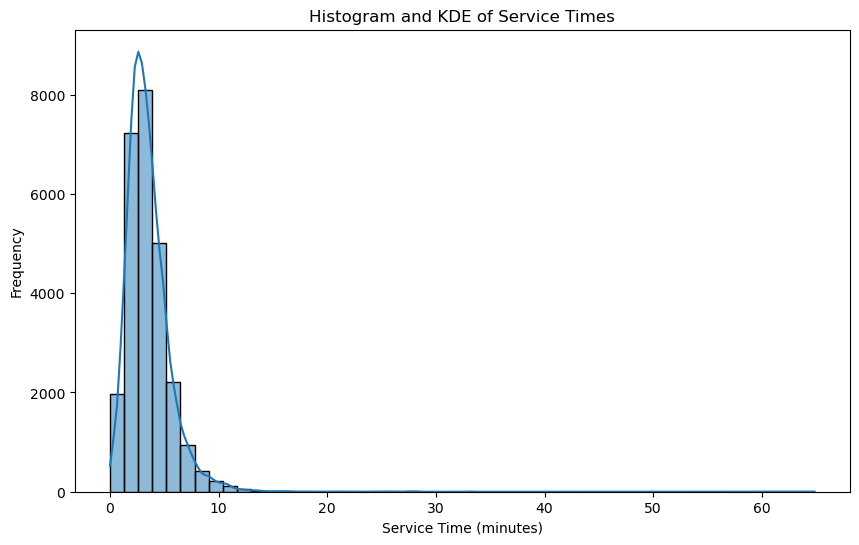

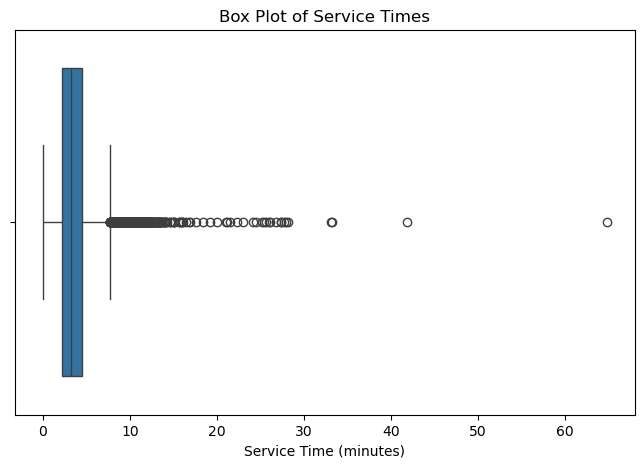

In [21]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(service_times, kde=True, bins=50) # Adjust bins as needed
plt.title('Histogram and KDE of Service Times')
plt.xlabel('Service Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# Box plot (to identify outliers)
plt.figure(figsize=(8, 5))
sns.boxplot(x=service_times)
plt.title('Box Plot of Service Times')
plt.xlabel('Service Time (minutes)')
plt.show()

In [22]:
service_times = service_times[service_times > 0] # Ensure positive values for distributions like exponential and log-normal

# --- Fit Exponential Distribution ---
# The exponential distribution is defined by a 'loc' (location) and 'scale' parameter.
# For service times, loc is often 0. The scale is 1/lambda (mean).
exp_params = stats.expon.fit(service_times)  # floc=0 fixes the location at 0
exp_dist = stats.expon(loc=exp_params[0], scale=exp_params[1])
print(f"Exponential Fit Parameters: loc={exp_params[0]}, scale={exp_params[1]} (mean={exp_params[1]})")

# --- Fit Log-Normal Distribution ---
# The log-normal distribution takes three parameters from scipy's fit:
# shape (s, which is sigma), loc (location offset), and scale (exp(mu)).
# If you expect your data to start from 0, you can set loc=0.
lognorm_params = stats.lognorm.fit(service_times) # floc=0 fixes the location at 0
lognorm_dist = stats.lognorm(s=lognorm_params[0], loc=lognorm_params[1], scale=lognorm_params[2])
print(f"Log-Normal Fit Parameters: shape(sigma)={lognorm_params[0]}, loc={lognorm_params[1]}, scale(exp(mu))={lognorm_params[2]}")

# You can also try other distributions like Gamma, Weibull, etc.
# --- Fit Gamma Distribution ---
# gamma_params = stats.gamma.fit(data, floc=0)
# gamma_dist = stats.gamma(a=gamma_params[0], loc=gamma_params[1], scale=gamma_params[2])
# print(f"Gamma Fit Parameters: shape(a)={gamma_params[0]}, loc={gamma_params[1]}, scale={gamma_params[2]}")

# --- Fit Weibull (Minimum) Distribution ---
# weibull_min_params = stats.weibull_min.fit(data, floc=0)
# weibull_min_dist = stats.weibull_min(c=weibull_min_params[0], loc=weibull_min_params[1], scale=weibull_min_params[2])
# print(f"Weibull Min Fit Parameters: shape(c)={weibull_min_params[0]}, loc={weibull_min_params[1]}, scale={weibull_min_params[2]}")

Exponential Fit Parameters: loc=0.02, scale=3.4991259737789653 (mean=3.4991259737789653)
Log-Normal Fit Parameters: shape(sigma)=0.3729782115414504, loc=-1.4322215688341433, scale(exp(mu))=4.612167350845283


In [23]:
exp_dist.kwds['loc'], exp_dist.kwds['scale']

(0.02, 3.4991259737789653)

In [24]:
exp_dist.dist.name

'expon'

In [25]:
lognorm_dist.kwds

{'s': np.float64(0.3729782115414504),
 'loc': -1.4322215688341433,
 'scale': np.float64(4.612167350845283)}

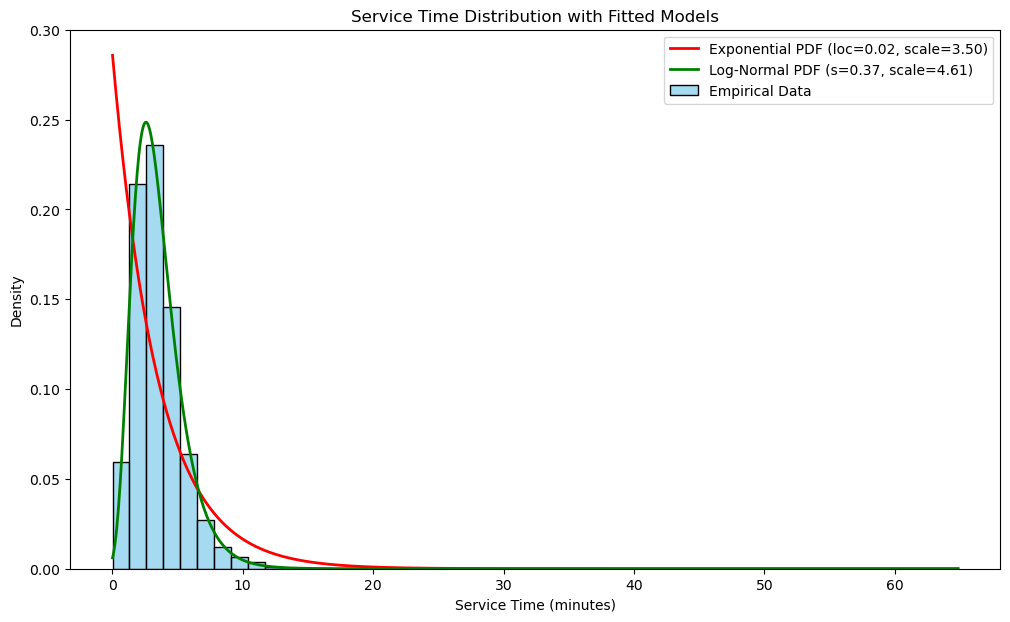

In [26]:
plt.figure(figsize=(12, 7))
sns.histplot(service_times, bins=50, stat='density', kde=False, label='Empirical Data', color='skyblue')

# Plot fitted distributions
x = np.linspace(service_times.min(), service_times.max(), 1000)

plt.plot(x, exp_dist.pdf(x), 'r-', lw=2, label=f'Exponential PDF (loc={exp_params[0]:.2f}, scale={exp_params[1]:.2f})')
plt.plot(x, lognorm_dist.pdf(x), 'g-', lw=2, label=f'Log-Normal PDF (s={lognorm_params[0]:.2f}, scale={lognorm_params[2]:.2f})')
# Add other distributions if you fitted them
# plt.plot(x, gamma_dist.pdf(x), 'm-', lw=2, label='Gamma PDF')
# plt.plot(x, weibull_min_dist.pdf(x), 'y-', lw=2, label='Weibull Min PDF')


plt.title('Service Time Distribution with Fitted Models')
plt.xlabel('Service Time (minutes)')
plt.ylabel('Density')
plt.legend()
plt.show()

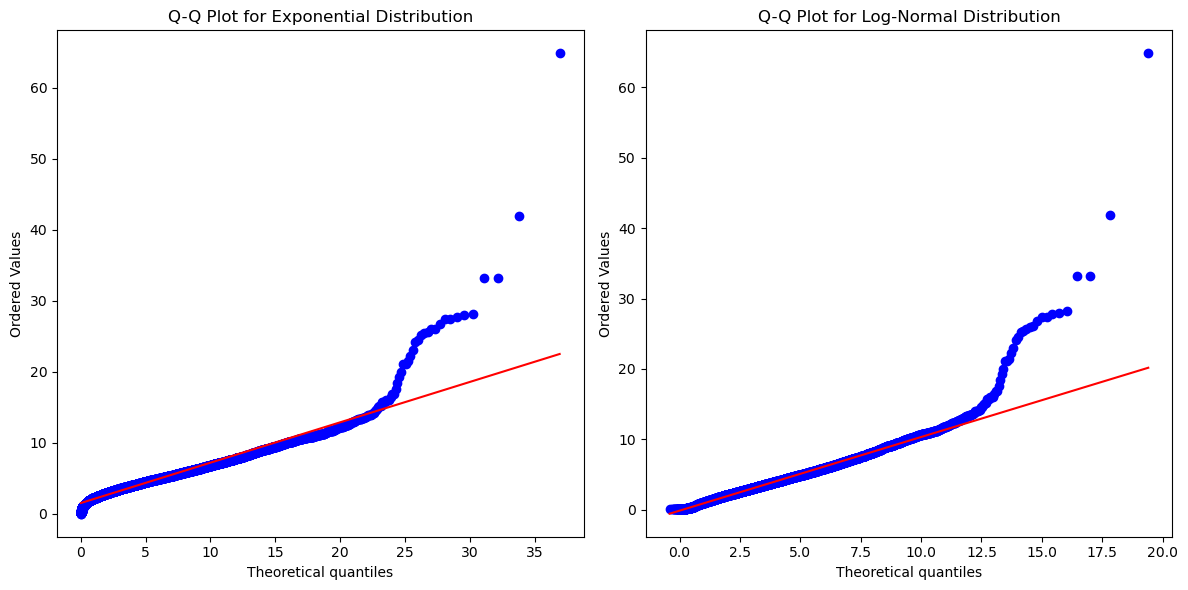

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(service_times, dist=exp_dist, plot=plt) # Using the fitted distribution object
plt.title('Q-Q Plot for Exponential Distribution')

plt.subplot(1, 2, 2)
stats.probplot(service_times, dist=lognorm_dist, plot=plt) # Using the fitted distribution object
plt.title('Q-Q Plot for Log-Normal Distribution')

plt.tight_layout()
plt.show()

In [28]:
# --- Kolmogorov-Smirnov Test ---
# For KS test, it's better to use the string name of the distribution if its parameters
# were estimated from the data, or pass the fully specified frozen distribution.

ks_stat_exp, ks_p_value_exp = stats.kstest(service_times, exp_dist.cdf) # Compare with the CDF of the fitted distribution
print(f"Exponential KS Test: Statistic={ks_stat_exp:.4f}, P-value={ks_p_value_exp:.4f}")

ks_stat_lognorm, ks_p_value_lognorm = stats.kstest(service_times, lognorm_dist.cdf)
print(f"Log-Normal KS Test: Statistic={ks_stat_lognorm:.4f}, P-value={ks_p_value_lognorm:.4f}")

# Note: The interpretation of p-values from KS test when parameters are estimated from data can be tricky.
# A common approach is to use it for relative comparison: a distribution with a smaller KS statistic
# (and often a larger p-value, though be cautious here) is generally preferred.

# --- Akaike Information Criterion (AIC) / Bayesian Information Criterion (BIC) ---
# These are useful for comparing models with different numbers of parameters.
# Lower AIC/BIC values indicate a better fit, penalizing model complexity.
# You usually need the log-likelihood for these. Scipy's fit methods don't directly
# return log-likelihood for all distributions, but the frozen distribution's logpdf can be used.

from scipy import stats
import numpy as np

def calculate_aic_bic(data, dist_frozen):
    """
    Calculates AIC and BIC for a given dataset and a frozen scipy distribution.

    Parameters:
    data (array-like): The data that was used to fit the distribution.
    dist_frozen (scipy.stats.rv_continuous_frozen): The frozen distribution object
                                                    (e.g., result of stats.expon(loc=l, scale=s)).

    Returns:
    tuple: (aic, bic)
    """
    log_likelihood = np.sum(dist_frozen.logpdf(data))
    
    k = 0  # Initialize k (number of estimated parameters)

    # Determine k based on the distribution type and how it was fitted in your example code.
    # This assumes 'floc=0' was used for fitting exponential and log-normal,
    # meaning 'loc' was fixed and not estimated.
    
    # Access the distribution name via dist_frozen.dist.name
    if dist_frozen.dist.name == stats.expon.name:
        # For stats.expon.fit(data, floc=0), 'loc' is fixed (at 0), 
        # and 'scale' is estimated.
        # Parameters for expon are (loc, scale).
        k = 1  # Only 'scale' was estimated.
    elif dist_frozen.dist.name == stats.lognorm.name:
        # For stats.lognorm.fit(data, floc=0), 'loc' is fixed (at 0),
        # 's' (shape) and 'scale' are estimated.
        # Parameters for lognorm are (s, loc, scale).
        k = 2  # 's' (shape) and 'scale' were estimated.
    elif dist_frozen.dist.name == stats.gamma.name:
        # If you also fitted gamma with floc=0:
        # Parameters for gamma are a (shape), loc, scale.
        # 'a' (shape) and 'scale' would be estimated.
        k = 2 
    elif dist_frozen.dist.name == stats.weibull_min.name:
        # If you also fitted weibull_min with floc=0:
        # Parameters for weibull_min are c (shape), loc, scale.
        # 'c' (shape) and 'scale' would be estimated.
        k = 2
    else:
        # If k is not explicitly defined for a distribution and its fitting method,
        # it's safer to raise an error. Calculating k generically for a frozen
        # distribution without knowing which parameters were fixed during fitting is error-prone.
        raise ValueError(
            f"The number of estimated parameters (k) for AIC/BIC calculation "
            f"is not specifically defined for the distribution: '{dist_frozen.dist.name}'. "
            f"Please update the 'calculate_aic_bic' function to include logic for this "
            f"distribution, considering any parameters that were fixed during the fitting process (e.g., using floc, fscale)."
        )

    n = len(data)
    if n == 0:
        # Handle empty data case to avoid log(0) or division by zero if n is used elsewhere.
        print("Warning: Empty data provided to calculate_aic_bic. Returning NaN for AIC/BIC.")
        return np.nan, np.nan 

    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood # np.log is natural logarithm
    
    return aic, bic


aic_exp, bic_exp = calculate_aic_bic(service_times, exp_dist)
aic_lognorm, bic_lognorm = calculate_aic_bic(service_times, lognorm_dist)

print(f"Exponential: AIC={aic_exp:.2f}, BIC={bic_exp:.2f}")
print(f"Log-Normal: AIC={aic_lognorm:.2f}, BIC={bic_lognorm:.2f}")

Exponential KS Test: Statistic=0.2467, P-value=0.0000
Log-Normal KS Test: Statistic=0.0189, P-value=0.0000
Exponential: AIC=118551.77, BIC=118559.95
Log-Normal: AIC=103232.54, BIC=103248.90


"A smaller KS statistic and a larger p-value suggest a better fit."

### Use src code

In [29]:
import sys
import os

# Get the absolute path of the current notebook's directory
notebook_dir = os.path.dirname(os.path.abspath("__file__")) # For .py files
# If in a Jupyter notebook, you might need:
# notebook_dir = os.getcwd() # Gets the directory where the notebook is running

# Get the absolute path of the project root (one level up from 'notebooks')
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

In [30]:
# Now import from src is possible
from src.services import distribution
from src.external_systems import distributions_scipy

In [31]:
distribution_model = distribution.Distribution()
exponential_distribution_model = distributions_scipy.ExponentialDistributionScipy()
clinics_df.dropna(subset='TimeInService_minutes').groupby(
    ['Sucursal', 'TurnoGrupo', 'TurnoTipo']
)['TimeInService_minutes'].apply(
    lambda x: distribution_model.fit_distribution(
        x, exponential_distribution_model
    )
)

Sucursal                  TurnoGrupo  TurnoTipo            
CULIACAN                  C           Citado                                  (0.65, 3.5046363636361106)
                          F           Cotizacion                               (1.05, 3.785257731958591)
                                      Folio Pagado                            (1.03, 2.6416949152540017)
                          N           Citados sin folio                        (0.55, 3.473358974358675)
                                      Solicitar Estudios                       (0.02, 4.157254564699423)
                          P           Atención Empresas                         (1.1, 2.681219512194919)
                                      Estudio Pendiente                       (0.58, 1.6916666666666664)
                                      Examen de la Vista                       (0.6, 2.1795937090430977)
                                      Triage                    (0.18000000000000002, 4.285279999999

La razón por la cual estamos separando en sucursal, tipo de turno y tipo de estudio es porque hemos visto que los tiempos de servicio varían entre en relación a estas variables. La variación del tiempo de servicio en relación al horario es baja, por eso no estamos considerando esa granularidad.

In [32]:
def show_pdf(series, dist: str):
    distribution_model = distribution.Distribution()

    # Plot histogram
    plt.figure(figsize=(12, 7))
    sns.histplot(
        series, bins=50, 
        stat='density', kde=False, 
        label='Empirical Data', color='skyblue'
    )
    # Plot fitted distribution
    x = np.linspace(series.min(), series.max(), 1000)
    
    if dist == 'expon':
        expon_distribution_model = distributions_scipy.ExponentialDistributionScipy()
        params = distribution_model.fit_distribution(
            series, expon_distribution_model
        )
        plt.plot(
            x, distribution_model.distribution.pdf(x), 
            'r-', lw=2, 
            label=f'Exponential PDF (loc={params[0]:.2f}, scale={params[1]:.2f})'
        )
    elif dist == 'lognorm':
        lognorm_distribution_model = distributions_scipy.LogNormalDistributionScipy()
        params = distribution_model.fit_distribution(
            series, lognorm_distribution_model
        )
        plt.plot(
            x, distribution_model.distribution.pdf(x), 
            'g-', lw=2, 
            label=f'Log-Normal PDF (s={params[0]:.2f}, scale={params[2]:.2f})'
        )
    else:
        raise ValueError(f'dist has to be either expon or lognorm, but not {dist}.')

    
    plt.title(f'Service Time Distribution for {series.name}')
    plt.xlabel('Service Time (minutes)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

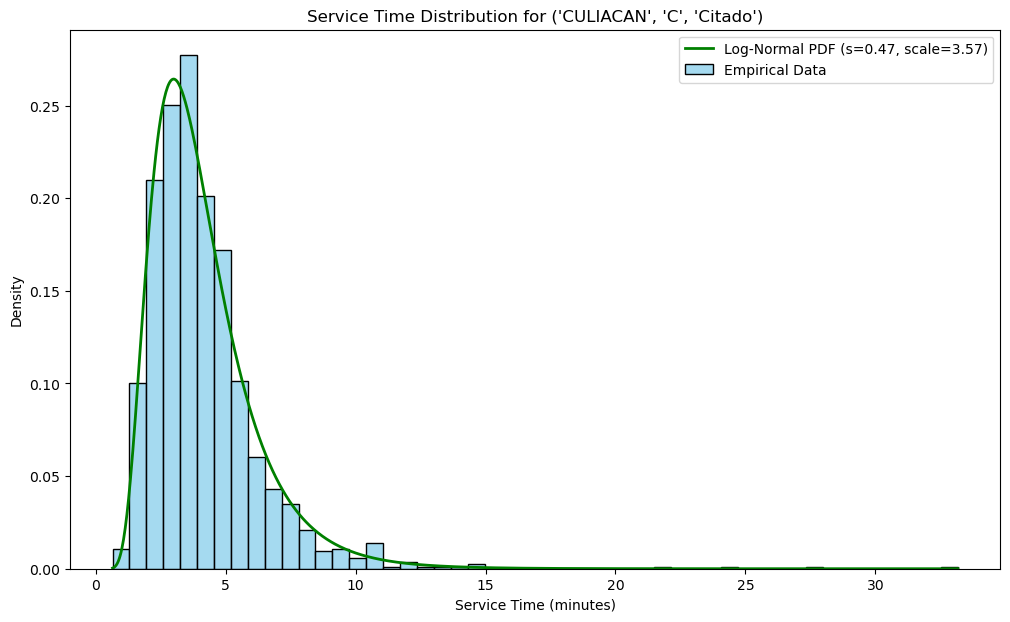

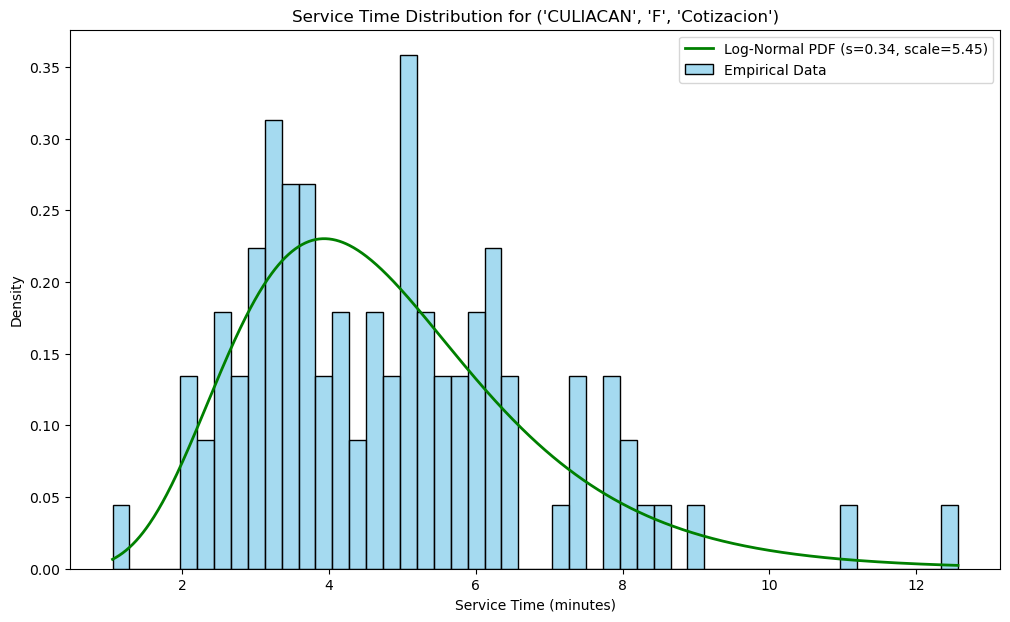

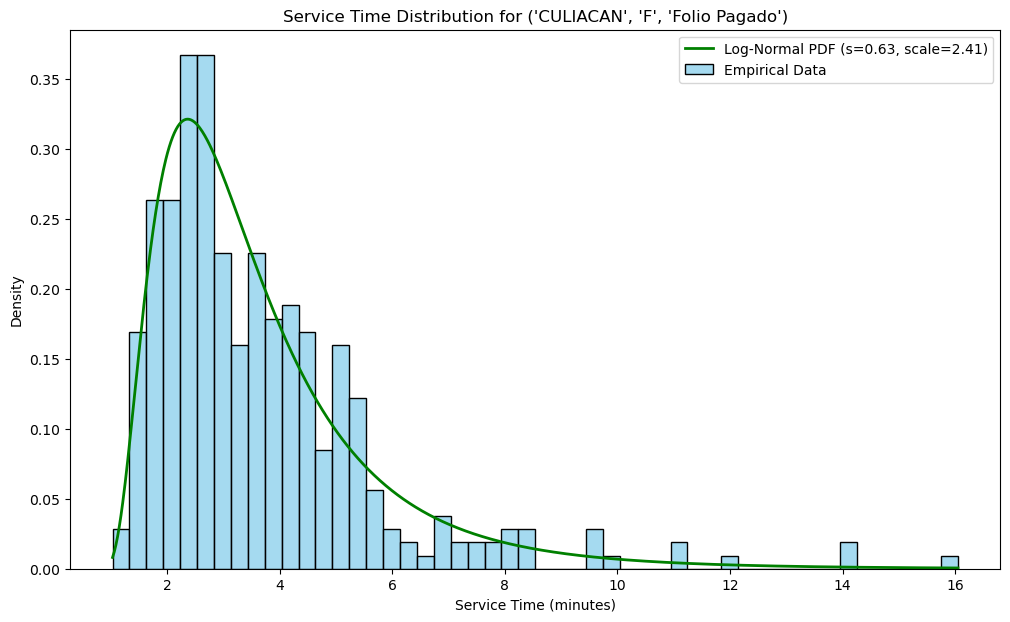

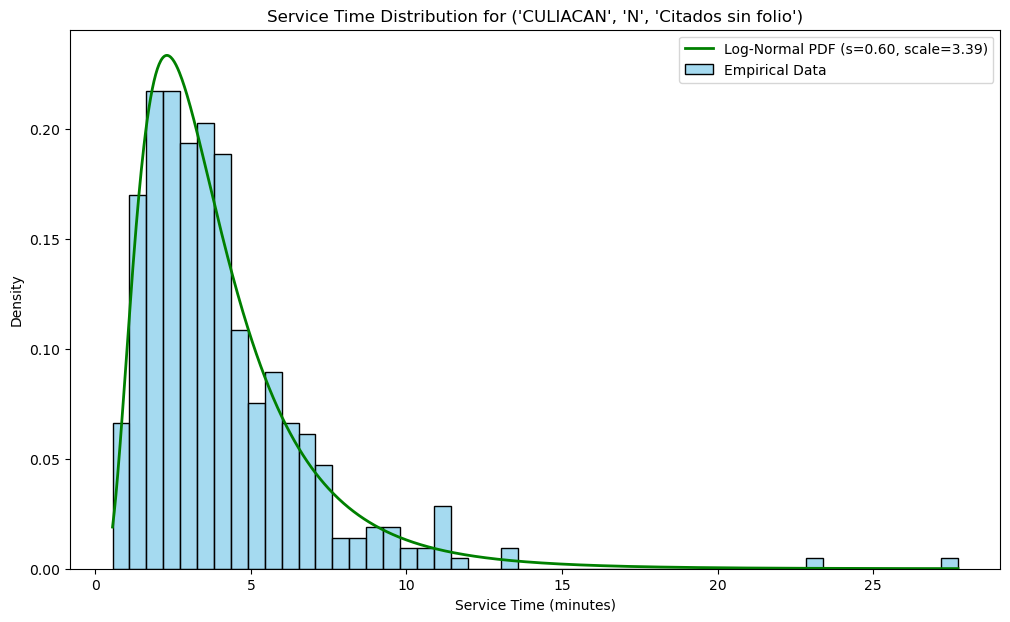

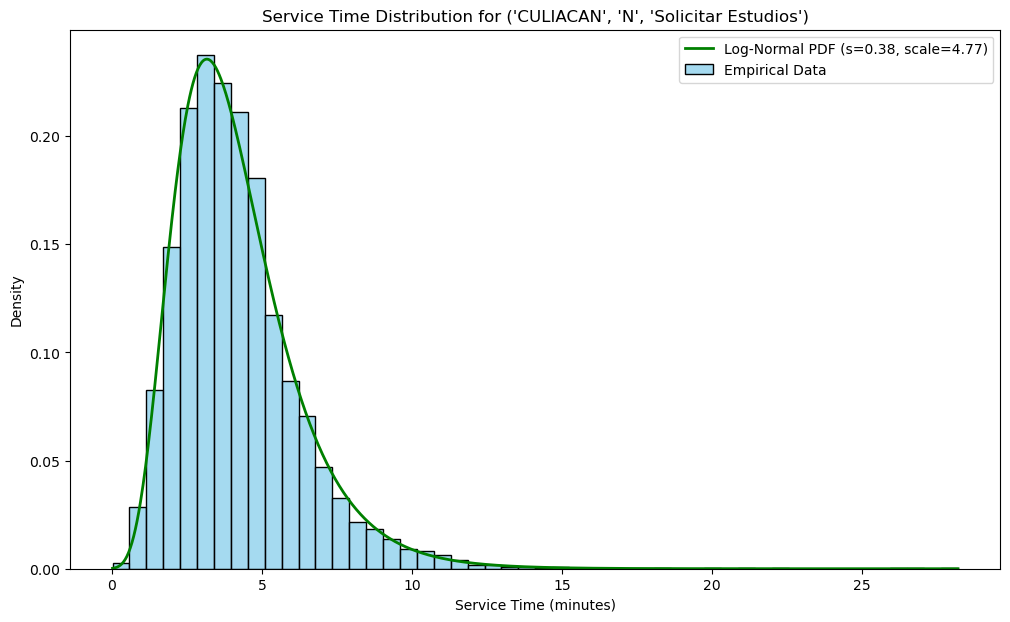

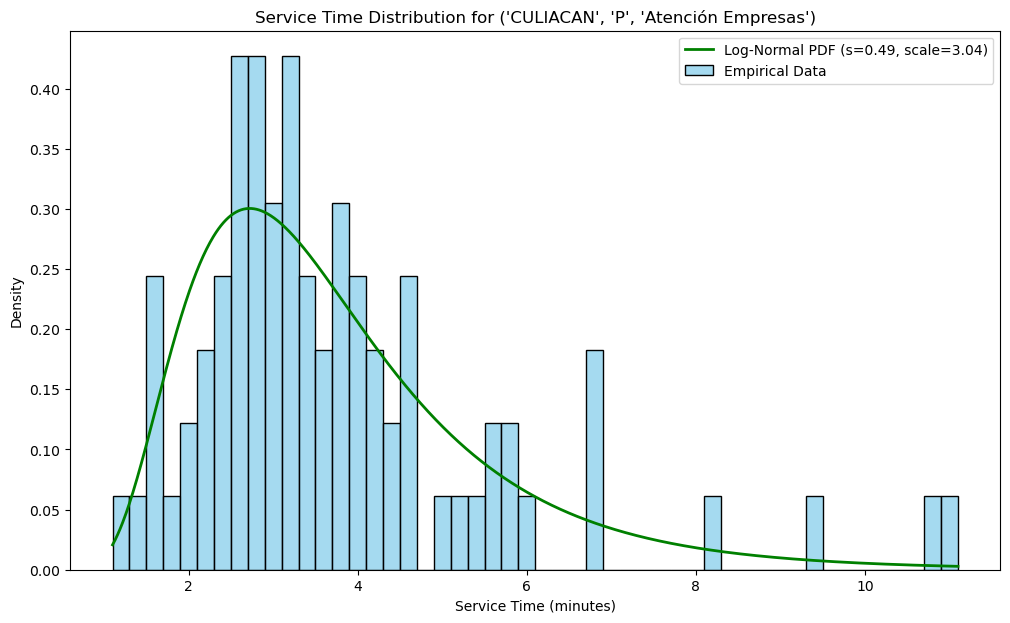

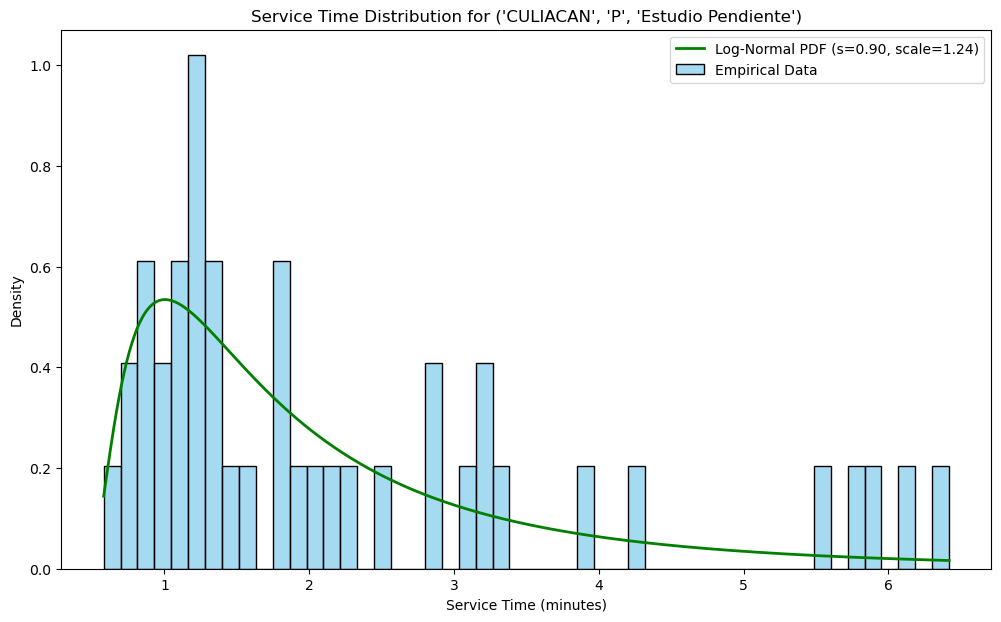

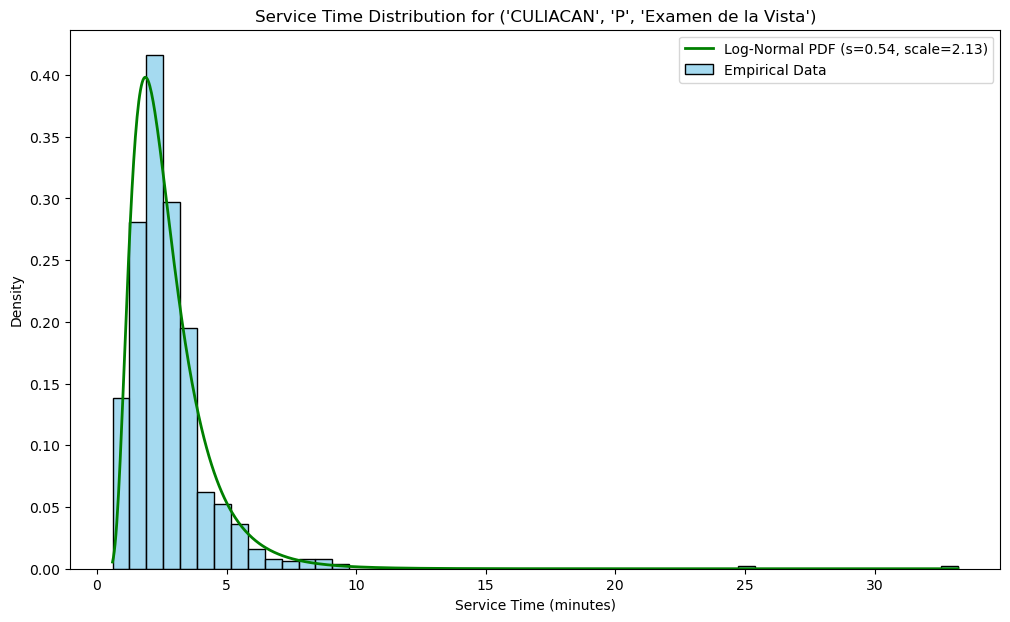

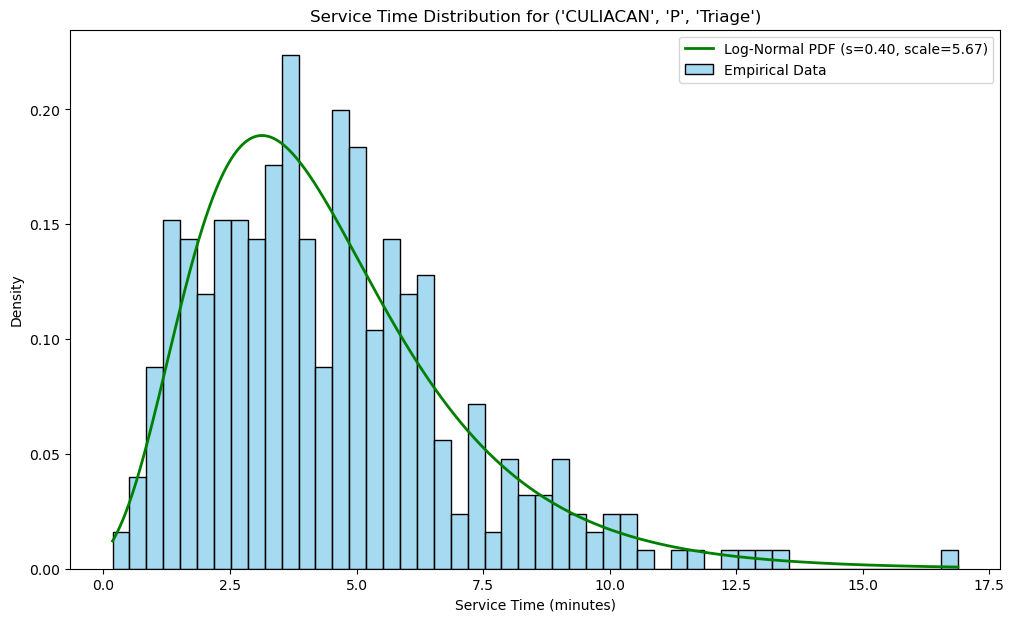

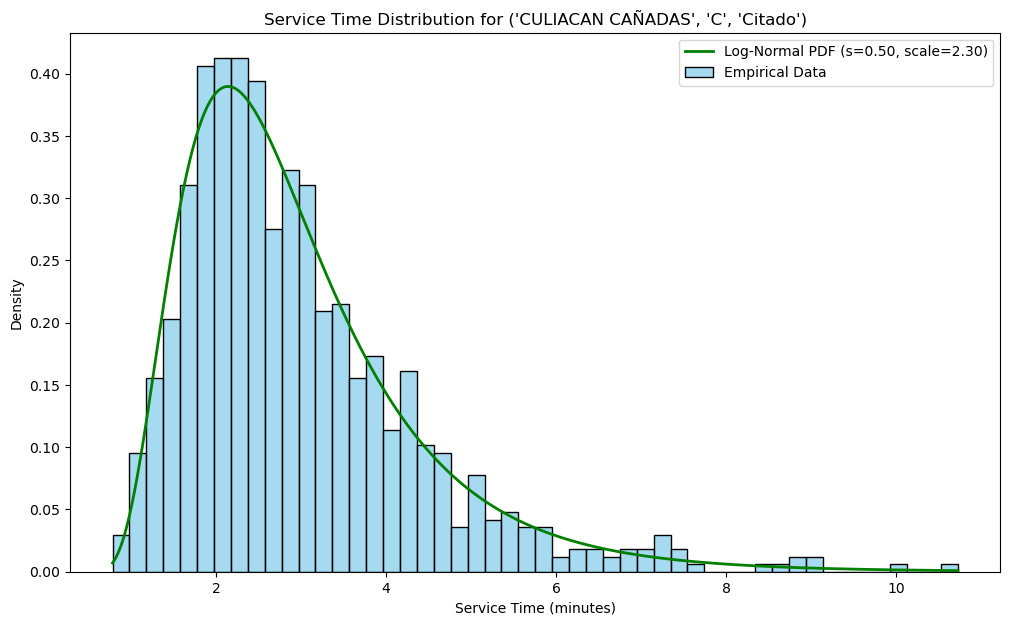

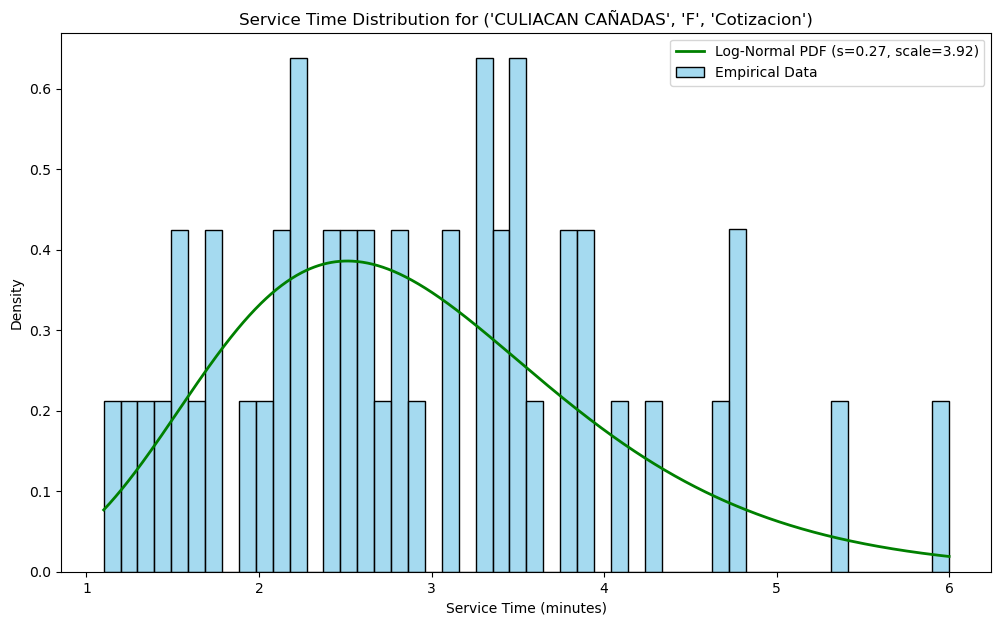

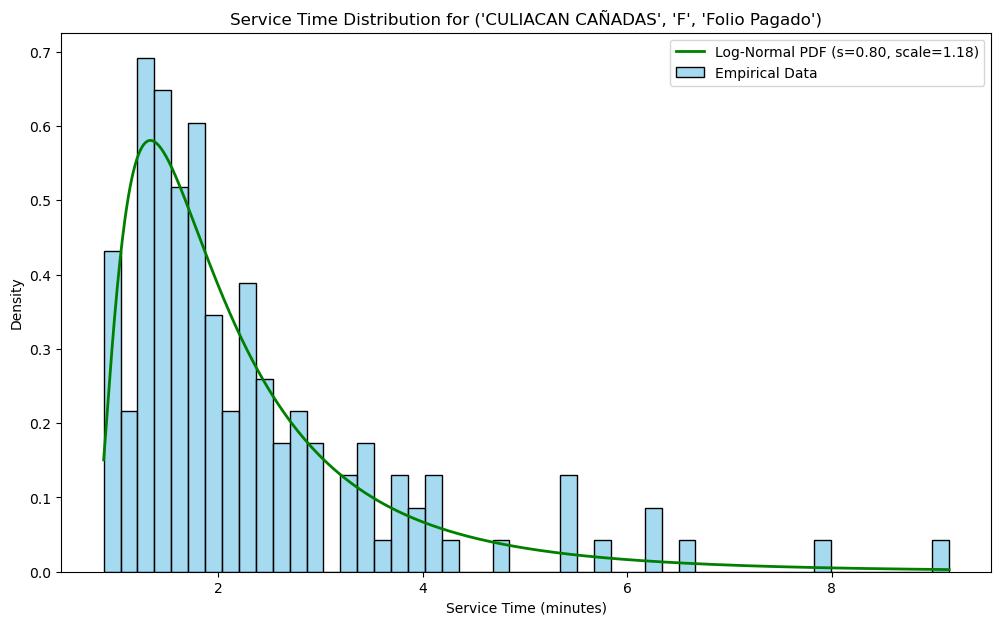

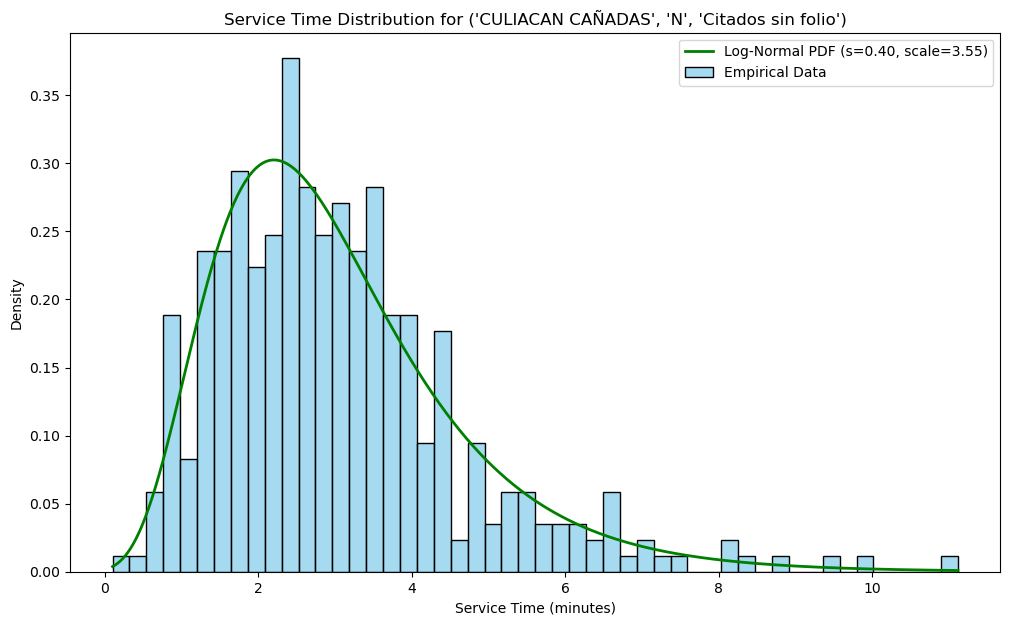

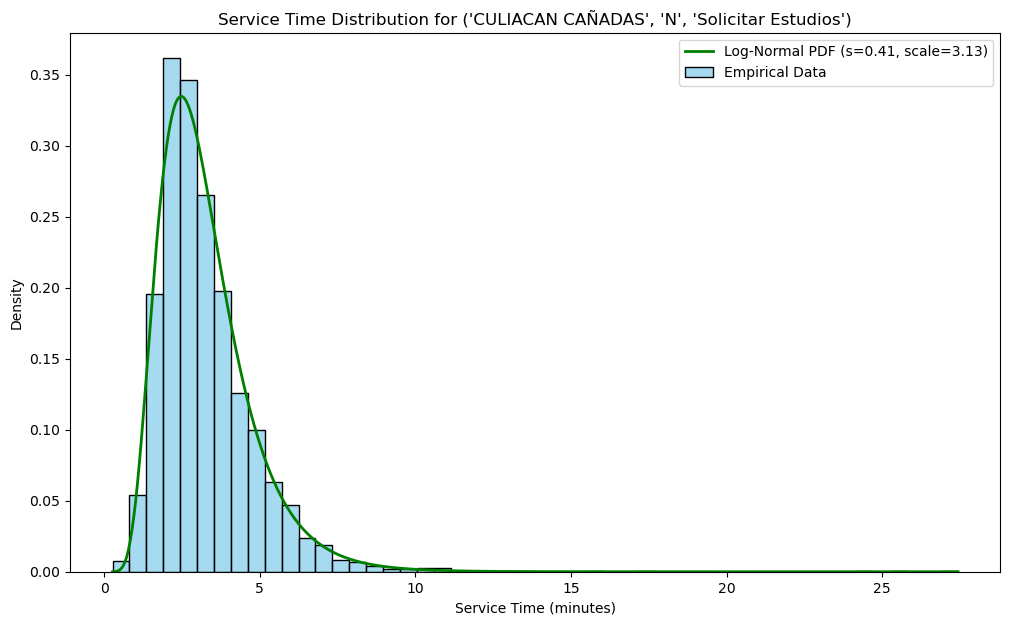

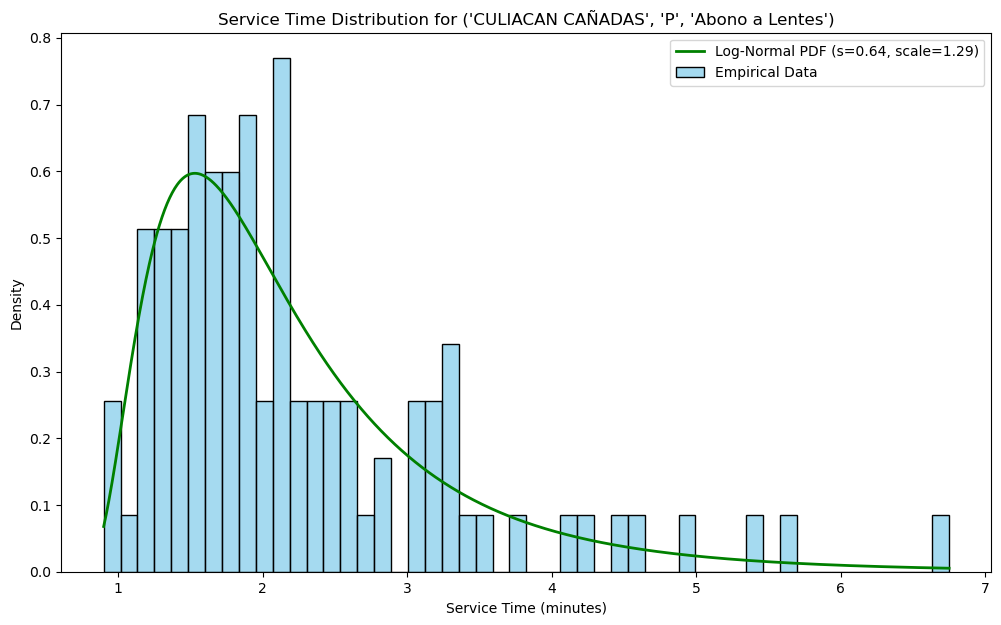

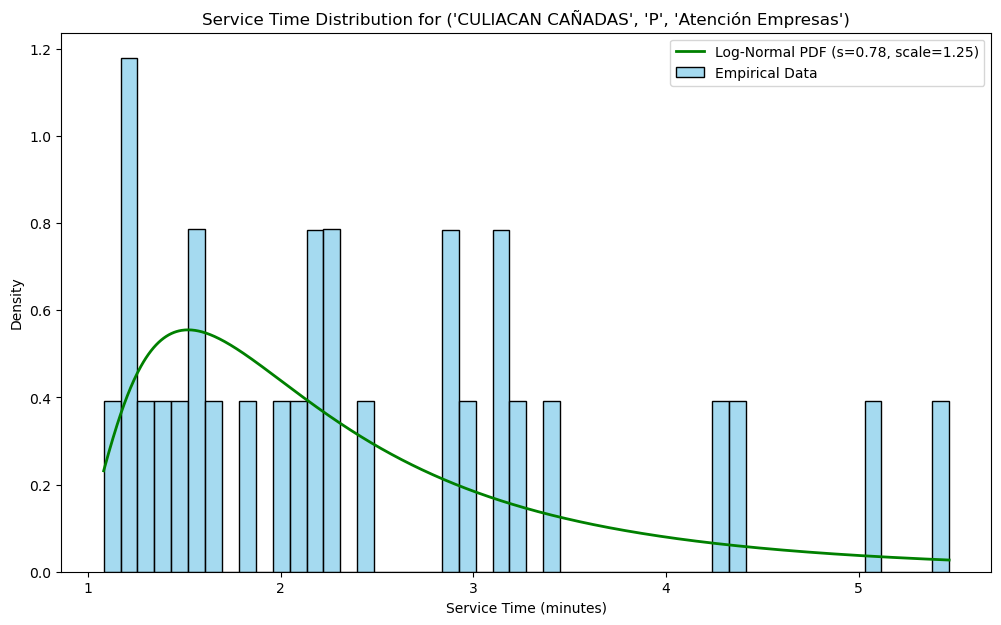

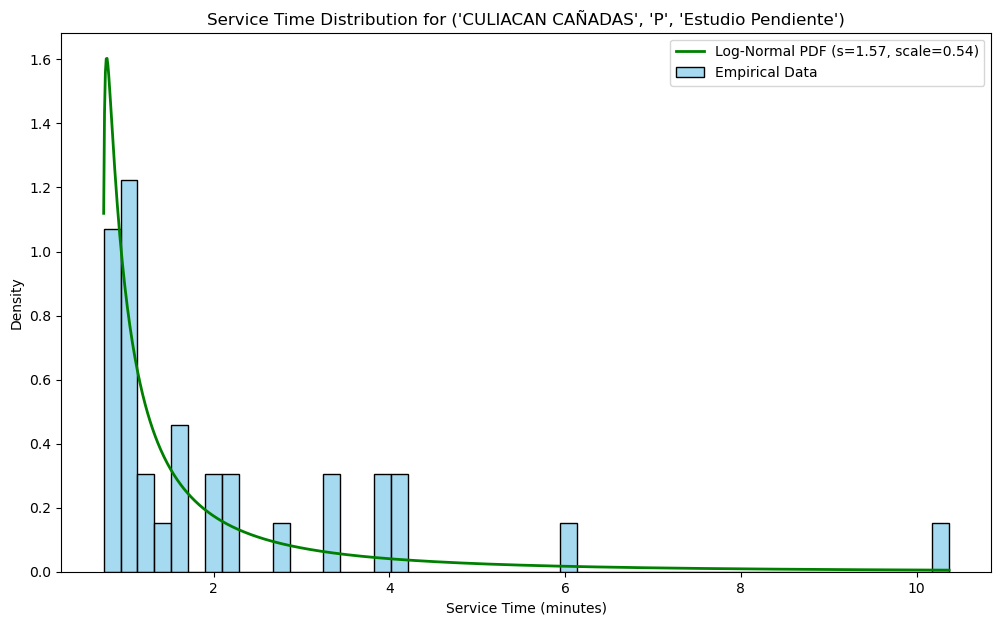

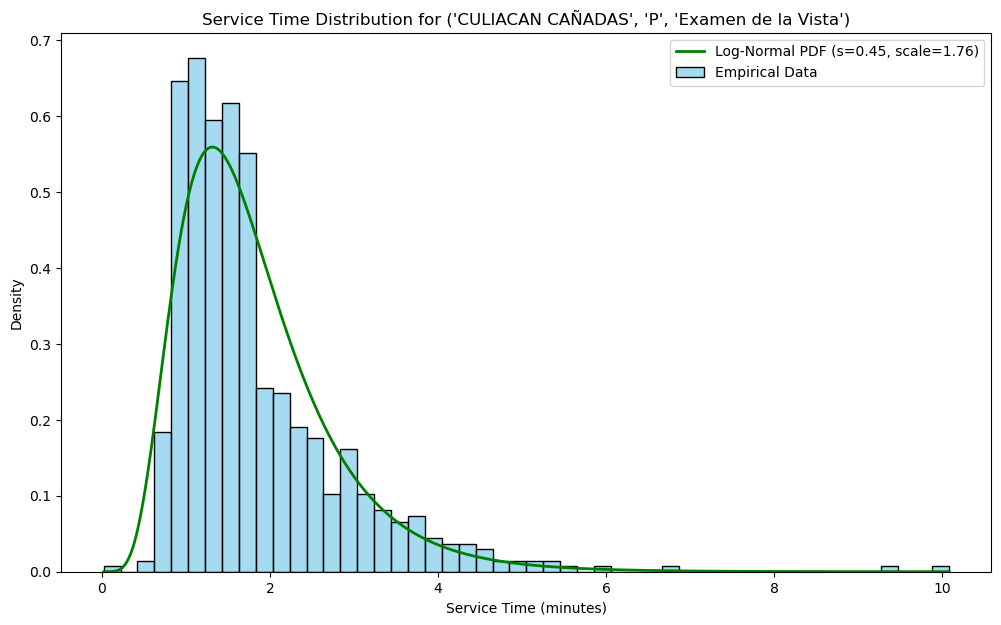

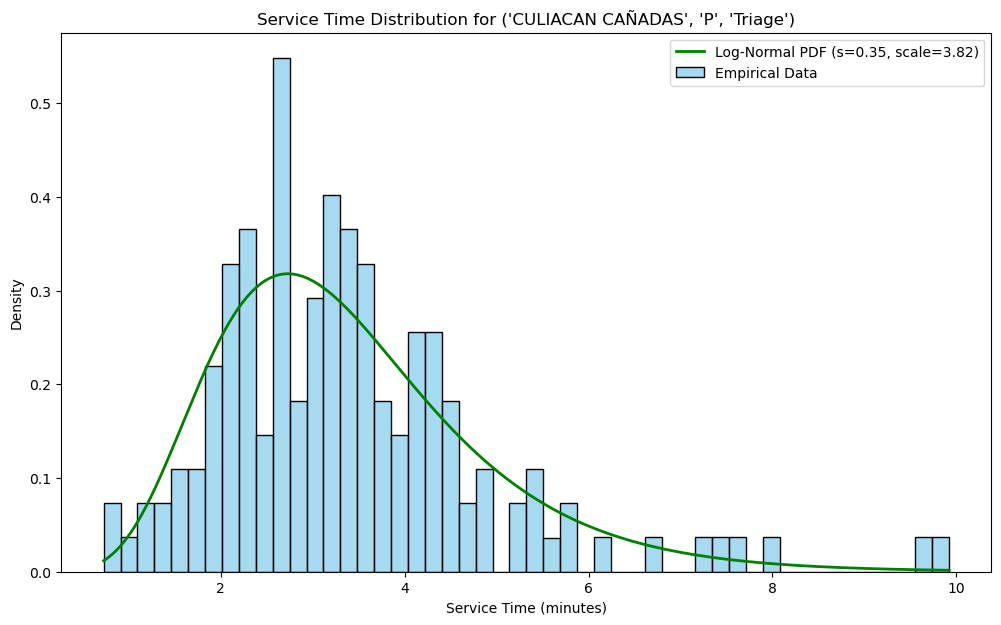

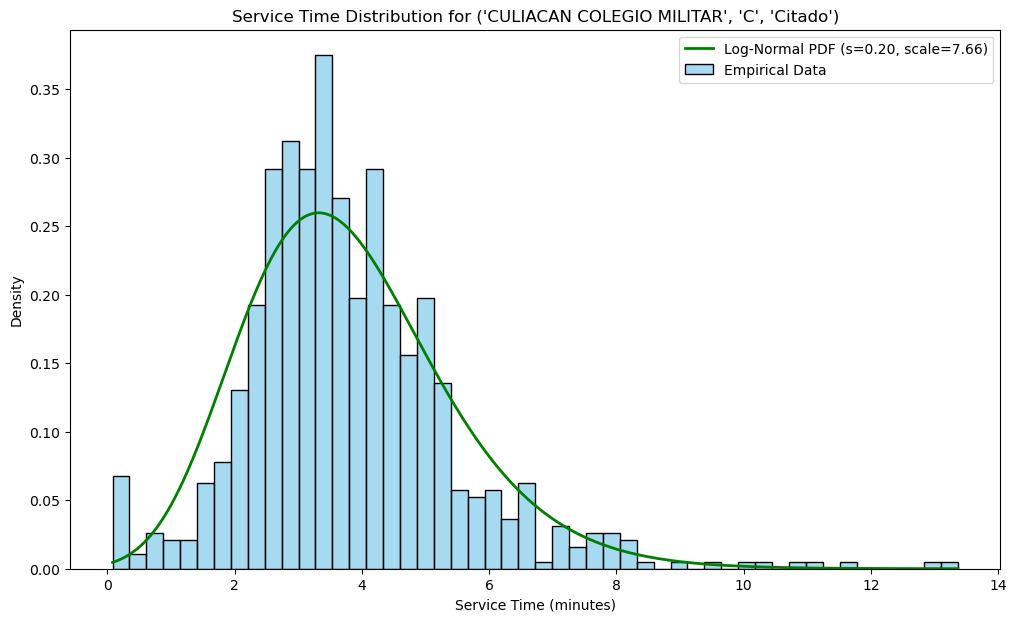

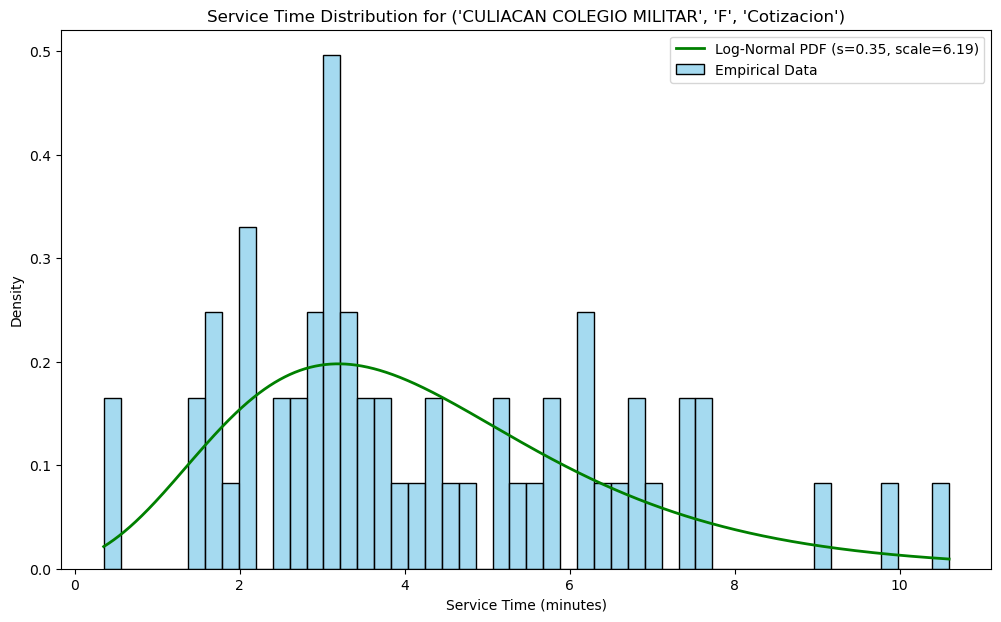

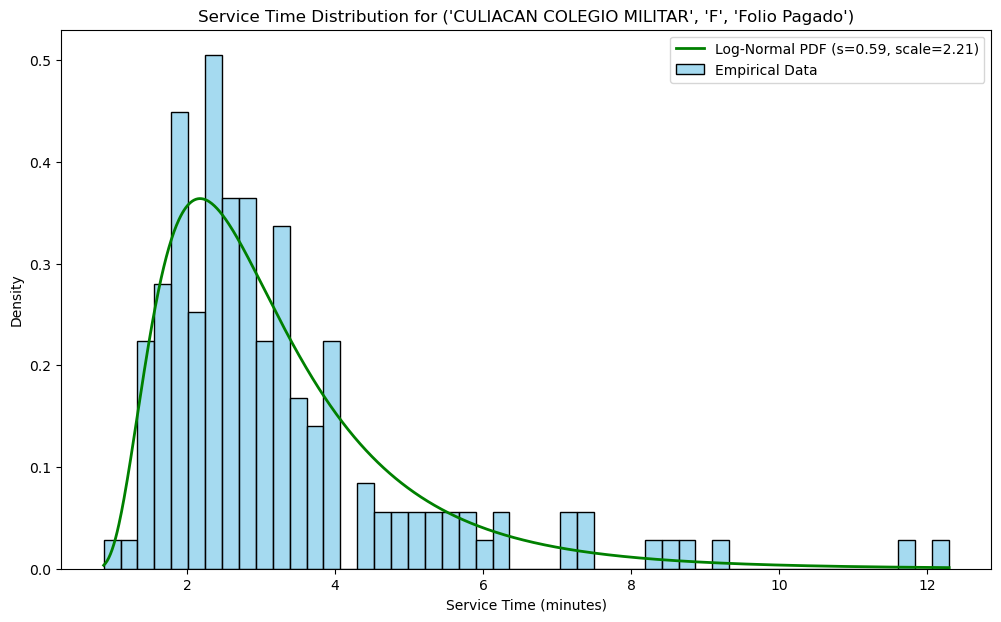

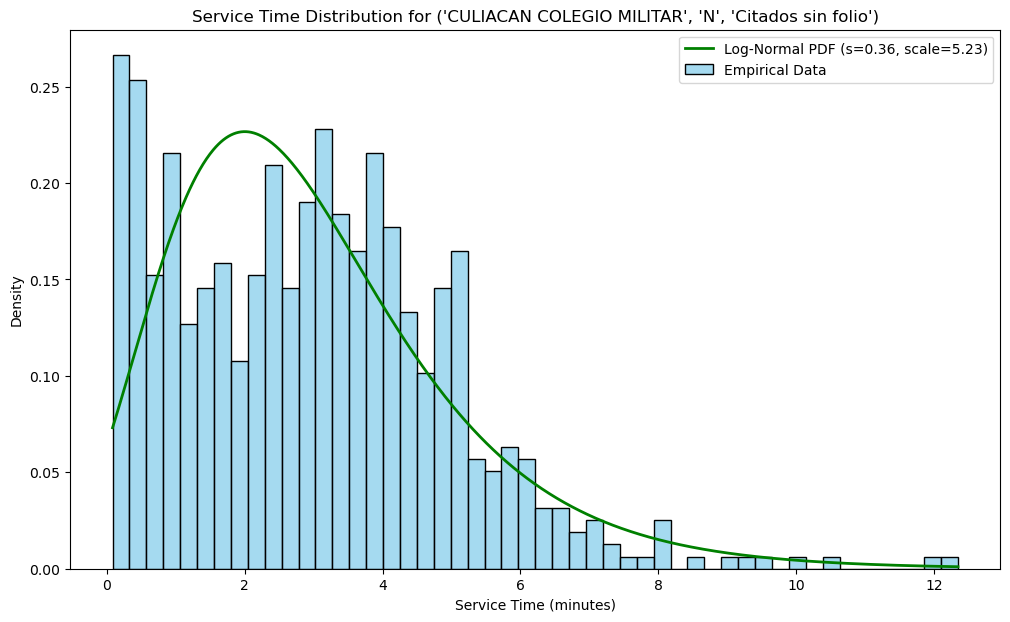

C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


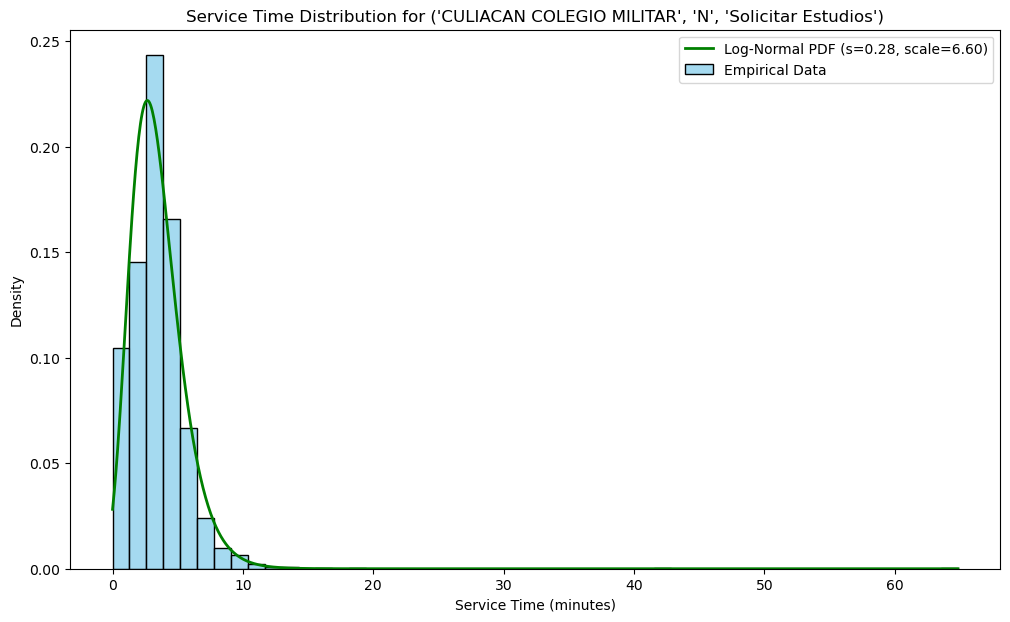

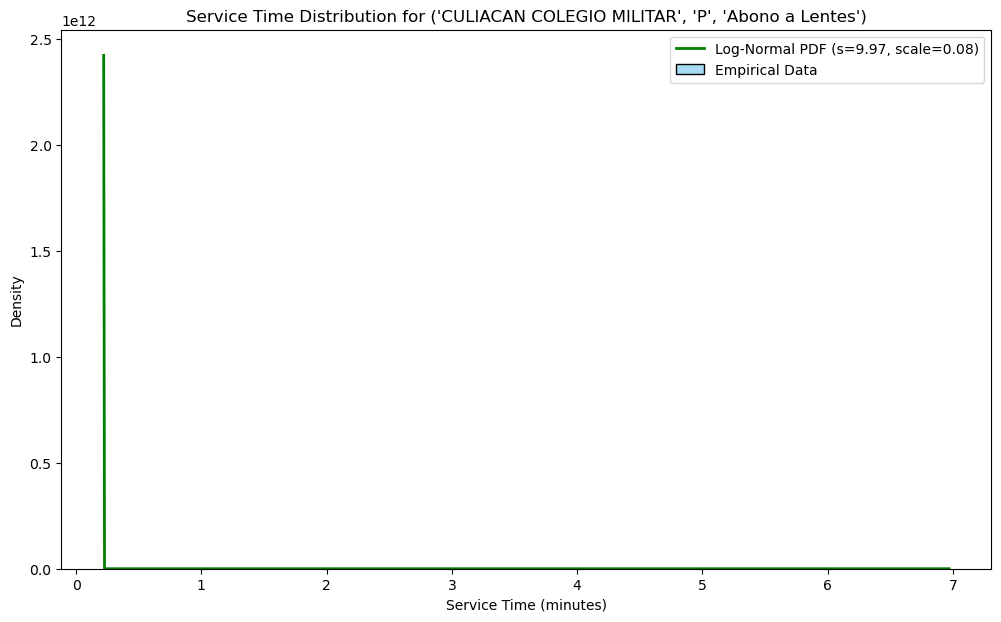

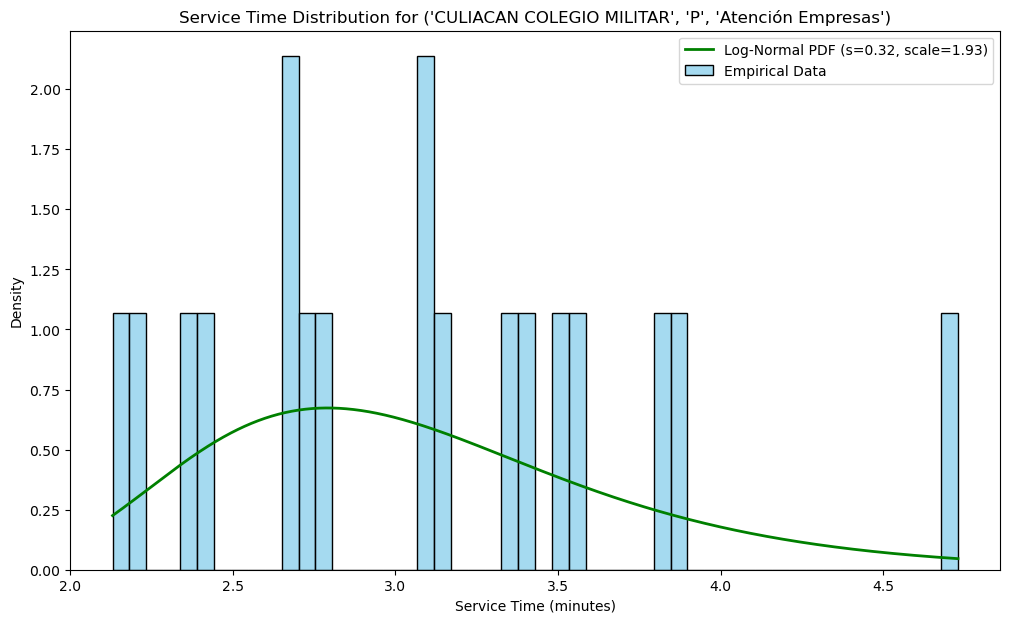

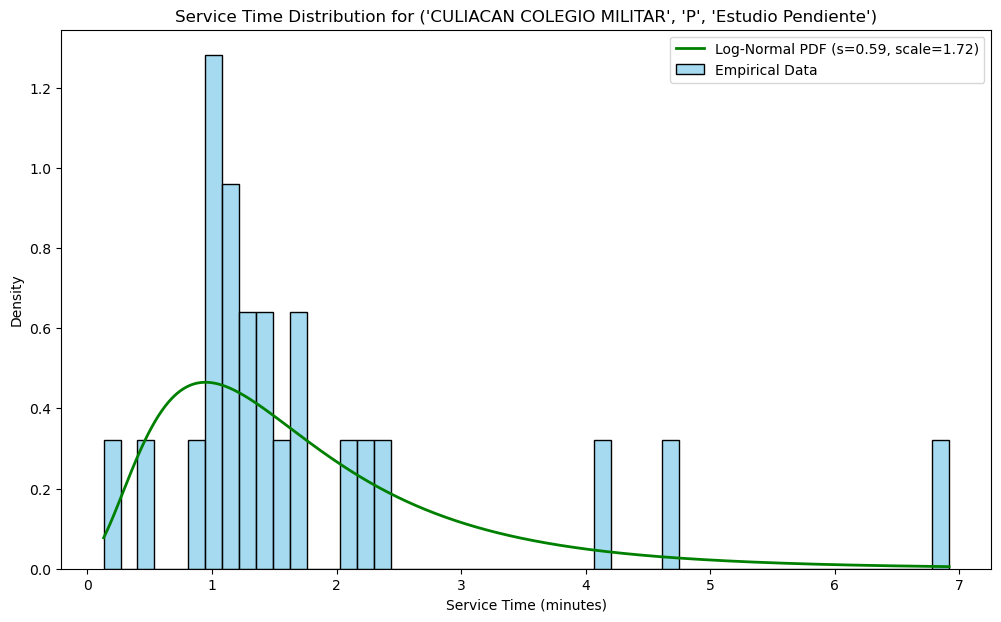

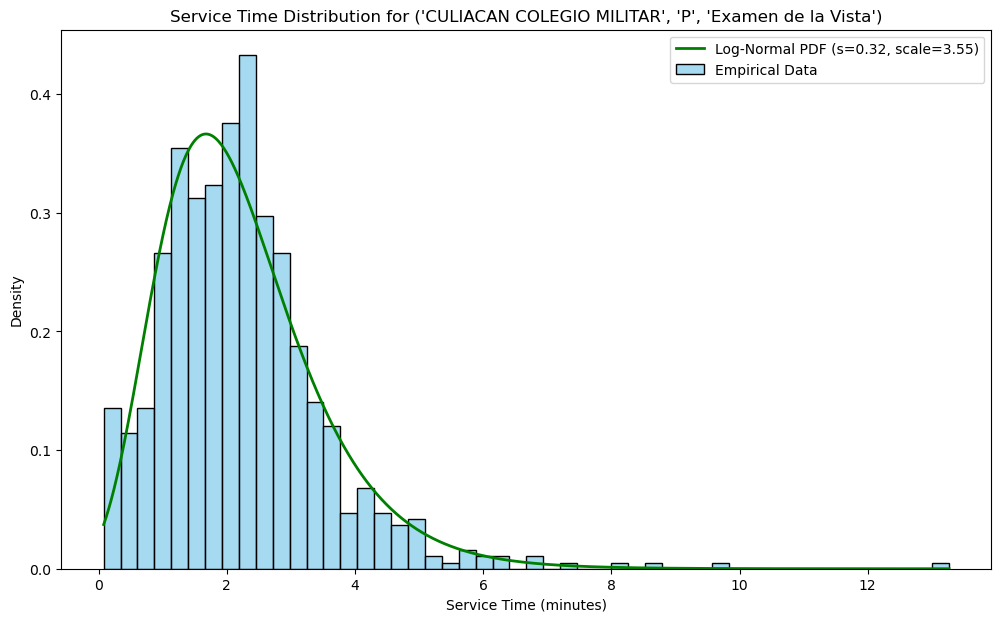

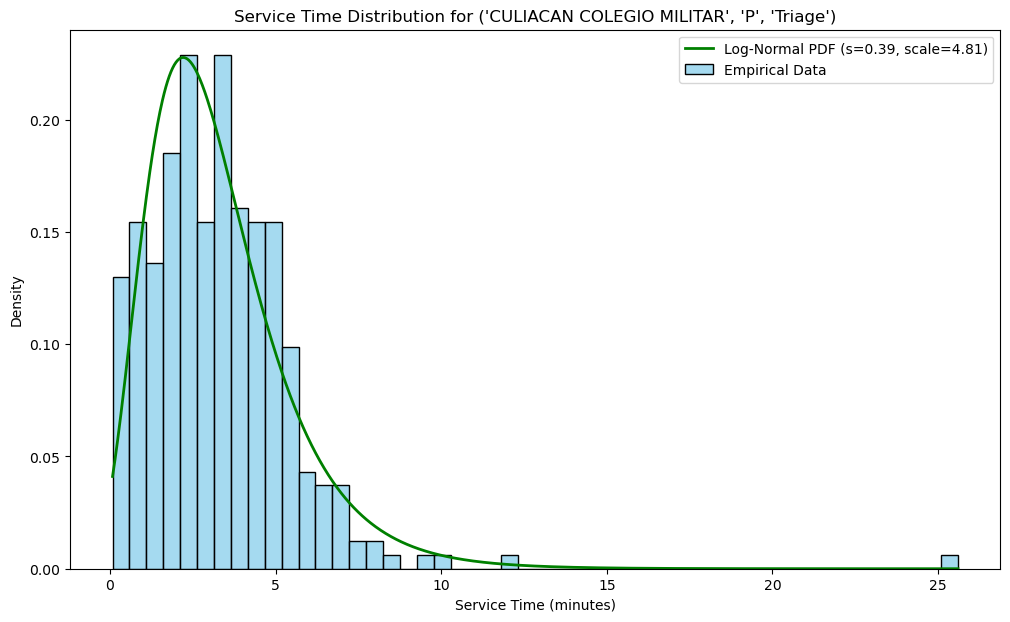

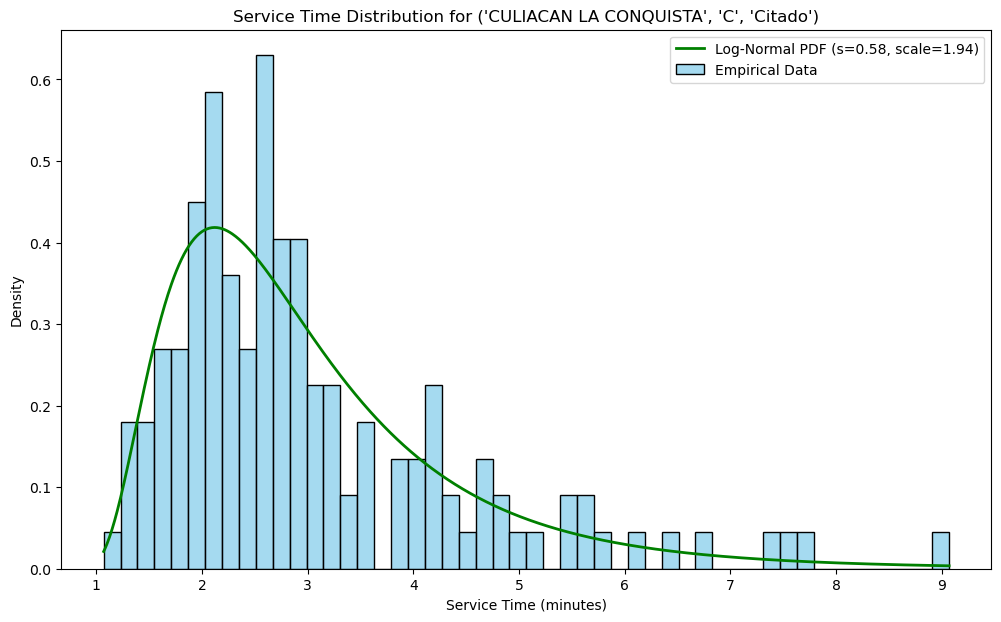

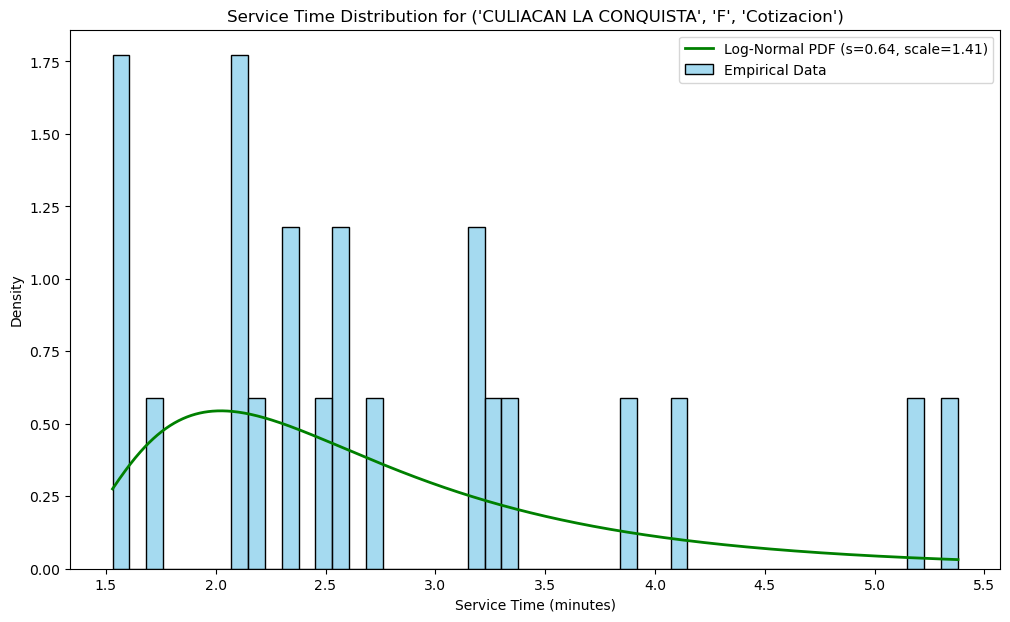

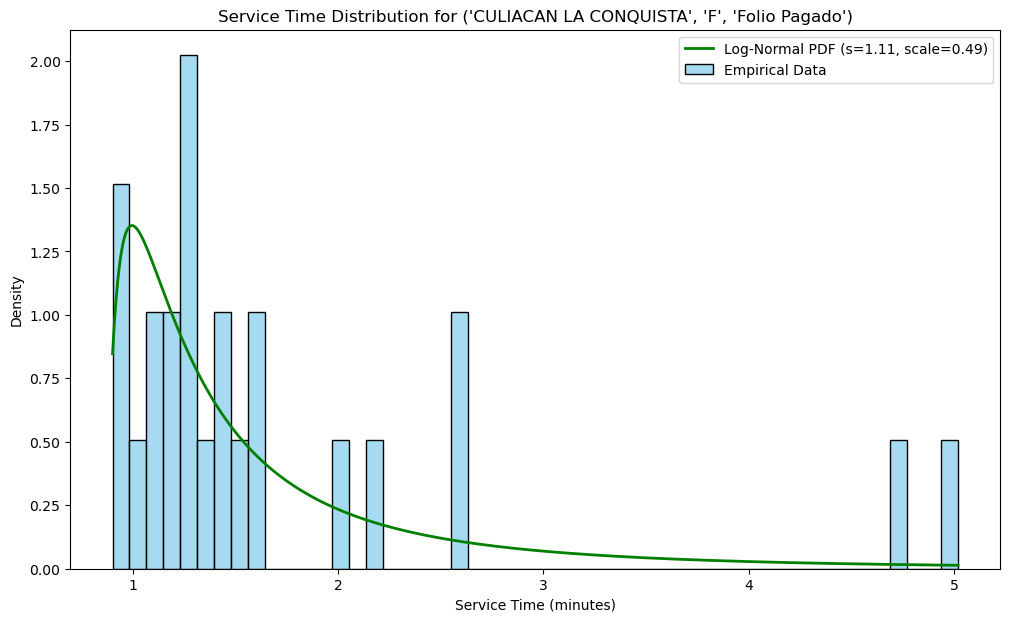

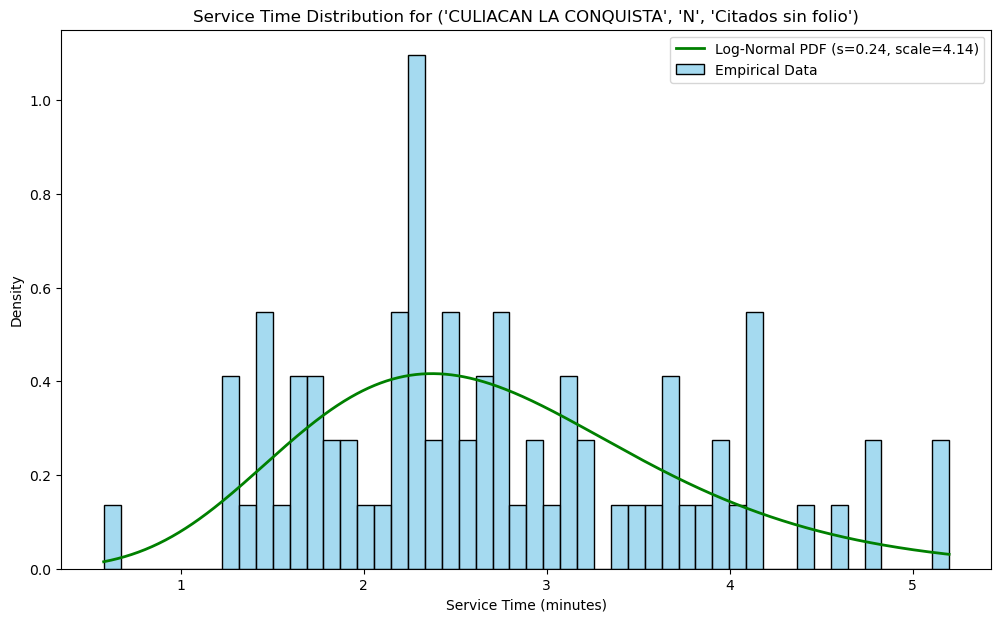

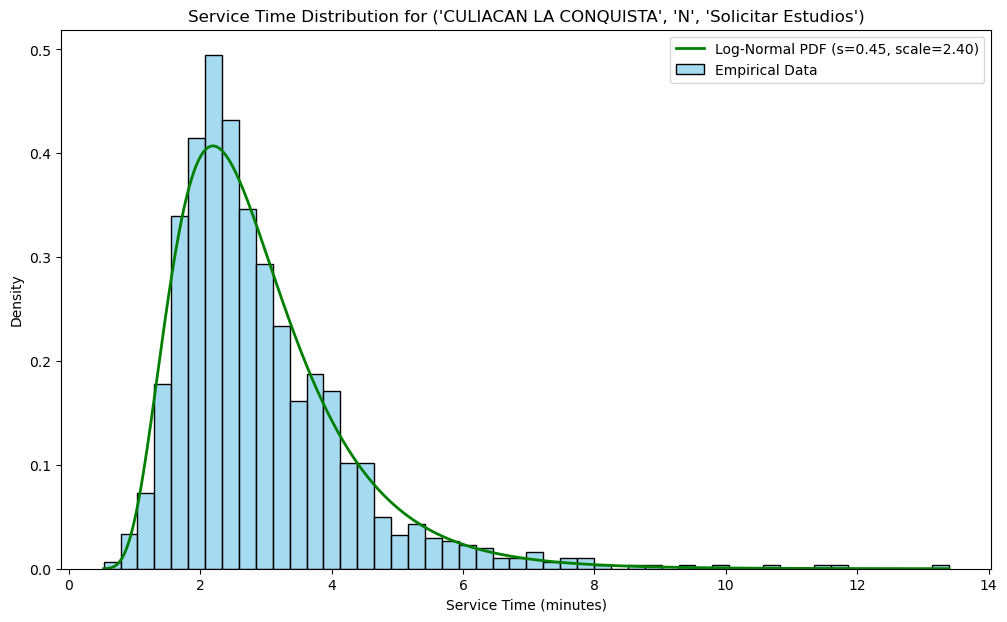

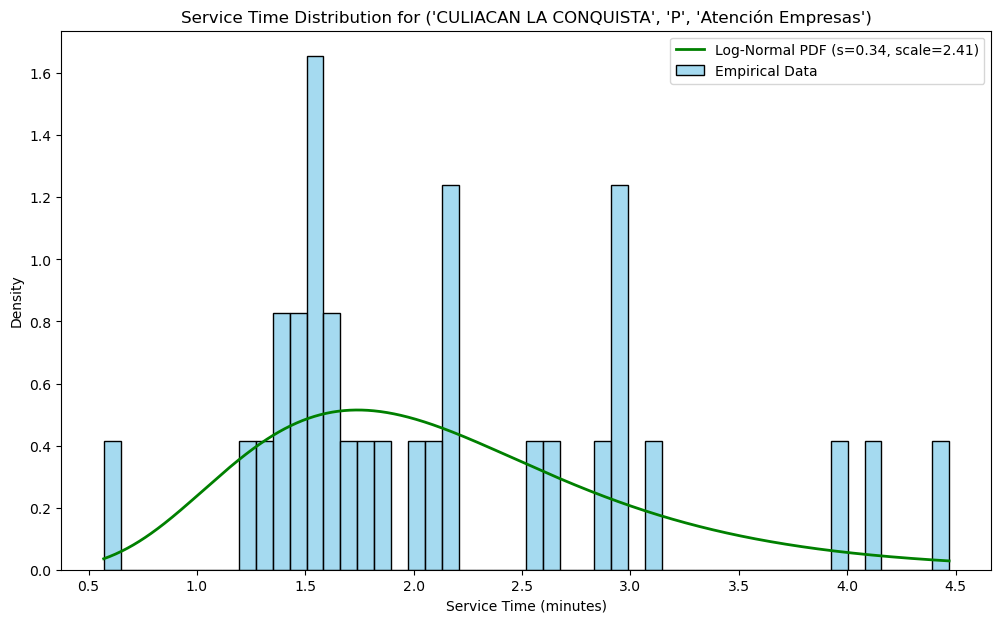

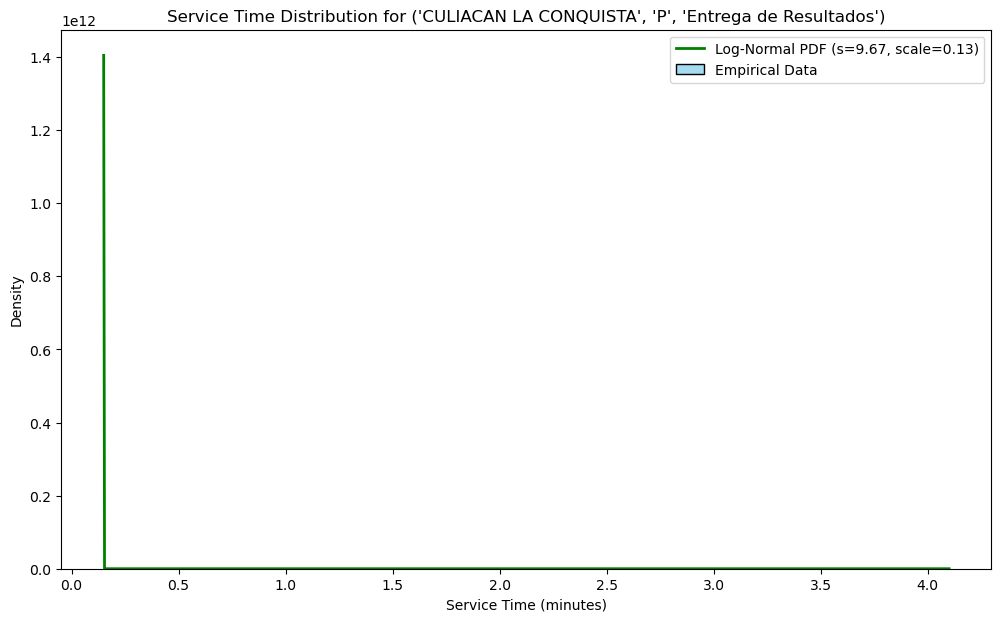

C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\scipy\stats\_continuous_distns.py:6780: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\scipy\stats\_continuous_distns.py:6781: RuntimeWarning: invalid value encountered in log
  - np.log(s * x * np.sqrt(2 * np.pi))),


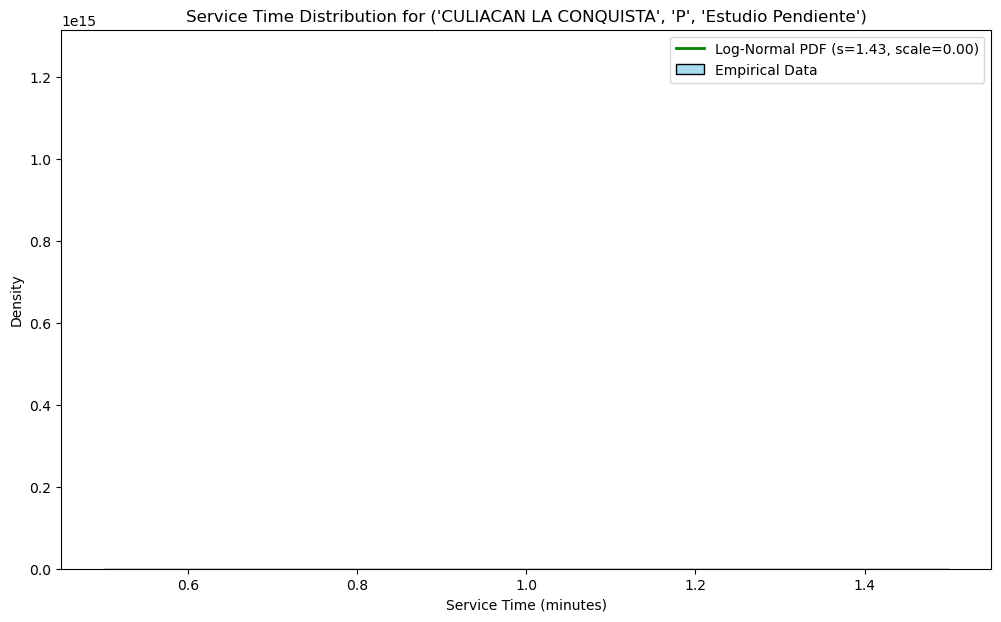

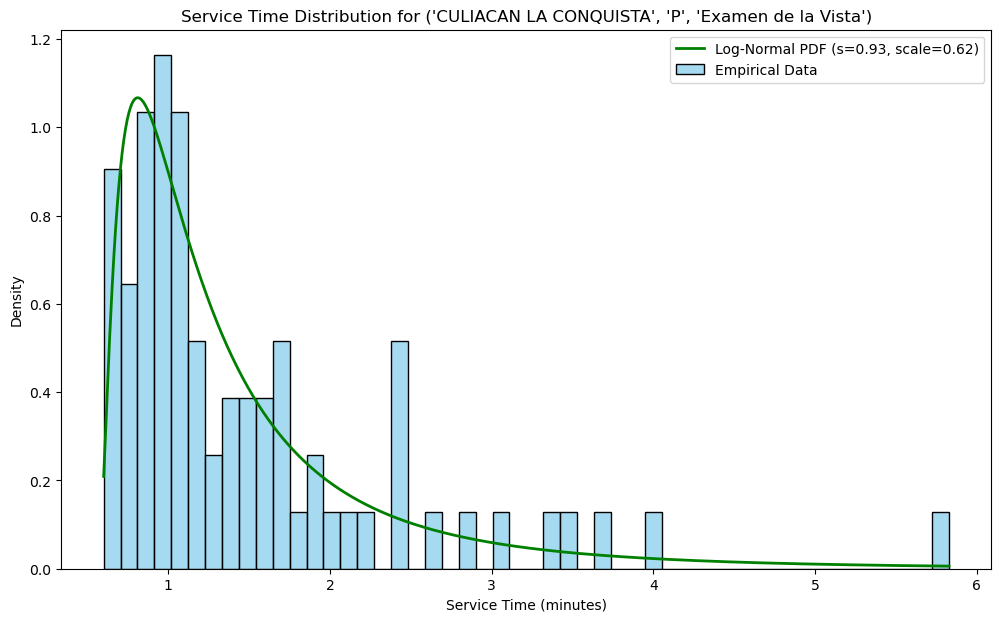

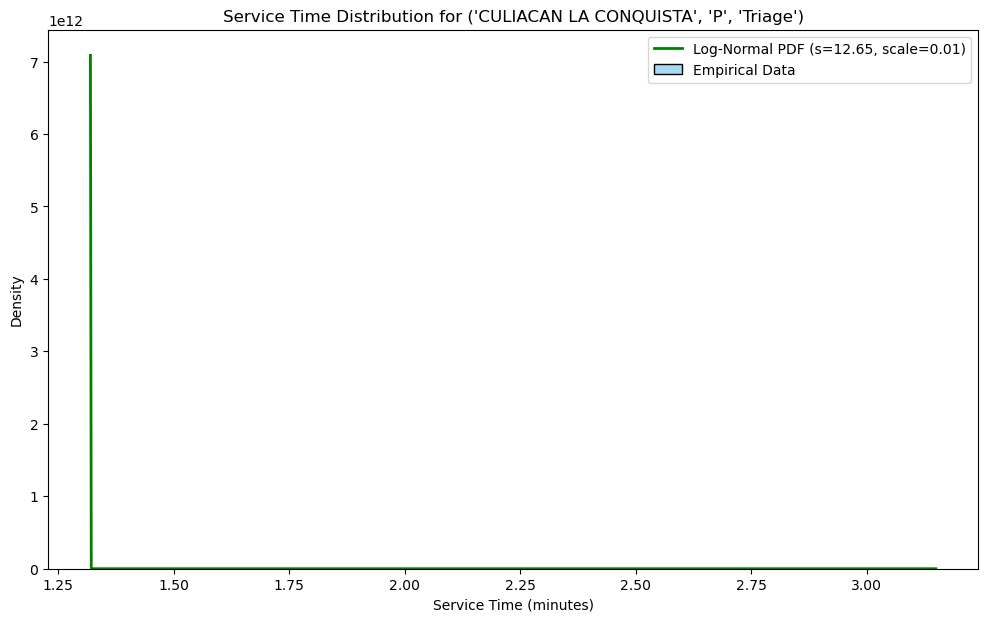

Sucursal                  TurnoGrupo  TurnoTipo            
CULIACAN                  C           Citado                   None
                          F           Cotizacion               None
                                      Folio Pagado             None
                          N           Citados sin folio        None
                                      Solicitar Estudios       None
                          P           Atención Empresas        None
                                      Estudio Pendiente        None
                                      Examen de la Vista       None
                                      Triage                   None
CULIACAN CAÑADAS          C           Citado                   None
                          F           Cotizacion               None
                                      Folio Pagado             None
                          N           Citados sin folio        None
                                      Solicitar Estudios

In [54]:
clinics_df.dropna(subset='TimeInService_minutes').groupby(
    ['Sucursal', 'TurnoGrupo', 'TurnoTipo']
)['TimeInService_minutes'].apply(
    lambda x: show_pdf(x)
)

## Waiting time analysis

In [33]:
# Convert TimeInService to total seconds
clinics_df['WaitingTimeInLine_seconds'] = clinics_df['WaitingTimeInLine'].dt.total_seconds()

# to minutes:
clinics_df['WaitingTimeInLine_minutes'] = clinics_df['WaitingTimeInLine'].dt.total_seconds() / 60

# It's crucial to handle any potential NaT (Not a Time) or negative timedelta values
# if they exist in your data, as they can cause errors in fitting.
# For example, you might want to remove or impute them:
waiting_times = clinics_df.dropna(subset=['WaitingTimeInLine_minutes'])['WaitingTimeInLine_minutes']
# service_time = clinics_df[clinics_df['TimeInService_seconds'] > 0] # Service time should be positive

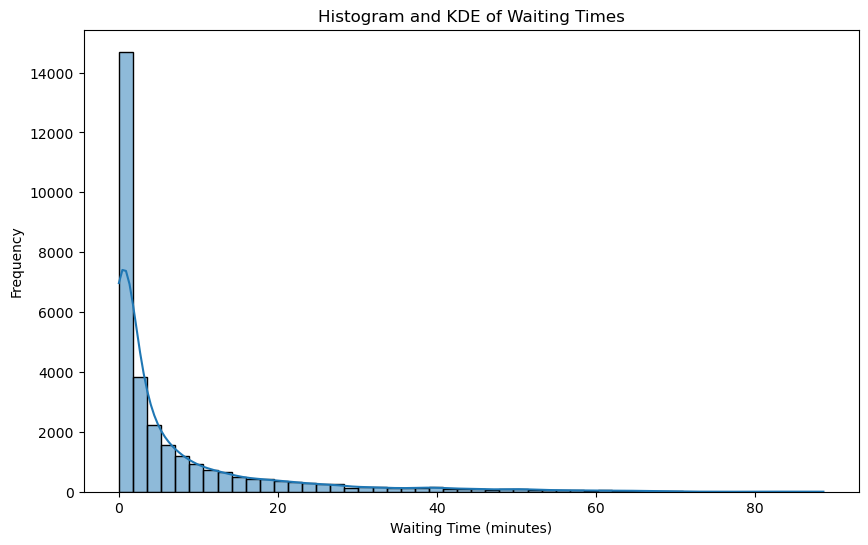

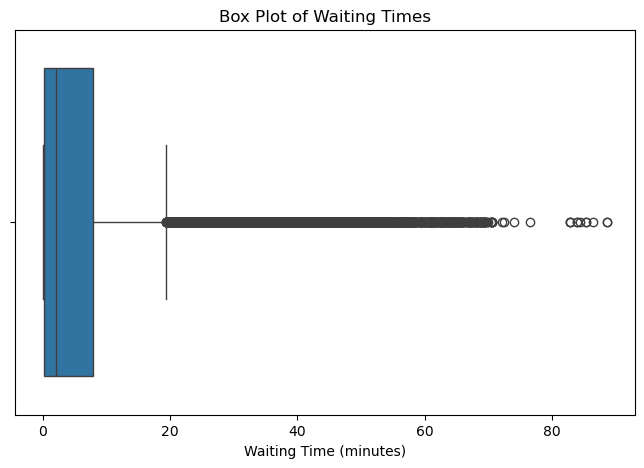

In [34]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(waiting_times, kde=True, bins=50) # Adjust bins as needed
plt.title('Histogram and KDE of Waiting Times')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# Box plot (to identify outliers)
plt.figure(figsize=(8, 5))
sns.boxplot(x=waiting_times)
plt.title('Box Plot of Waiting Times')
plt.xlabel('Waiting Time (minutes)')
plt.show()

In [35]:
def kolmogorov_test(data, dist):
    ks_stat, ks_p_value = stats.kstest(
        data, dist.distribution.cdf
    ) # Compare with the CDF of the fitted distribution
    return ks_stat, ks_p_value


def calculate_aic_bic(data, dist_frozen):
    """
    Calculates AIC and BIC for a given dataset and a frozen scipy distribution.

    Parameters:
    data (array-like): The data that was used to fit the distribution.
    dist_frozen (scipy.stats.rv_continuous_frozen): The frozen distribution object
                                                    (e.g., result of stats.expon(loc=l, scale=s)).

    Returns:
    tuple: (aic, bic)
    """
    log_likelihood = np.sum(dist_frozen.distribution.logpdf(data))
    
    k = 0  # Initialize k (number of estimated parameters)

    # Determine k based on the distribution type and how it was fitted in your example code.
    # This assumes 'floc=0' was used for fitting exponential and log-normal,
    # meaning 'loc' was fixed and not estimated.
    
    # Access the distribution name via dist_frozen.dist.name
    if dist_frozen.distribution.dist.name == stats.expon.name:
        # For stats.expon.fit(data, floc=0), 'loc' is fixed (at 0), 
        # and 'scale' is estimated.
        # Parameters for expon are (loc, scale).
        k = 1  # Only 'scale' was estimated.
    elif dist_frozen.distribution.dist.name == stats.lognorm.name:
        # For stats.lognorm.fit(data, floc=0), 'loc' is fixed (at 0),
        # 's' (shape) and 'scale' are estimated.
        # Parameters for lognorm are (s, loc, scale).
        k = 2  # 's' (shape) and 'scale' were estimated.
    elif dist_frozen.distribution.dist.name == stats.gamma.name:
        # If you also fitted gamma with floc=0:
        # Parameters for gamma are a (shape), loc, scale.
        # 'a' (shape) and 'scale' would be estimated.
        k = 2 
    elif dist_frozen.distribution.dist.name == stats.weibull_min.name:
        # If you also fitted weibull_min with floc=0:
        # Parameters for weibull_min are c (shape), loc, scale.
        # 'c' (shape) and 'scale' would be estimated.
        k = 2
    else:
        # If k is not explicitly defined for a distribution and its fitting method,
        # it's safer to raise an error. Calculating k generically for a frozen
        # distribution without knowing which parameters were fixed during fitting is error-prone.
        raise ValueError(
            f"The number of estimated parameters (k) for AIC/BIC calculation "
            f"is not specifically defined for the distribution: '{dist_frozen.dist.name}'. "
            f"Please update the 'calculate_aic_bic' function to include logic for this "
            f"distribution, considering any parameters that were fixed during the fitting process (e.g., using floc, fscale)."
        )

    n = len(data)
    if n == 0:
        # Handle empty data case to avoid log(0) or division by zero if n is used elsewhere.
        print("Warning: Empty data provided to calculate_aic_bic. Returning NaN for AIC/BIC.")
        return np.nan, np.nan 

    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood # np.log is natural logarithm
    
    return aic, bic



def test_distribution_fit(data, dist):
    ks_stat, ks_p_value = kolmogorov_test(data, dist)
    aic, bic = calculate_aic_bic(data, dist)

    return ks_stat, aic, bic


def choose_best_distribution(data, distributions: dict[str: stats.rv_continuous]):
    test_results = {}
    for dist in distributions:
        ks_stat, aic, bic = test_distribution_fit(data, distributions[dist])
        test_results[dist] = (ks_stat, aic, bic, sum([ks_stat, aic, bic]))
    return sorted(list(test_results.items()), key=lambda x: x[1][0])[0][0]


def fit_distributions(data):
    # initialize distribution objects
    distributions = {
        "expon": distributions_scipy.ExponentialDistributionScipy(),
        "lognorm": distributions_scipy.LogNormalDistributionScipy(),
    }
    # fit distributions and get parameters
    for dist in distributions:
        distribution_model = distribution.Distribution()
        distribution_model.fit_distribution(
            data, distributions[dist]
        )
        distributions[dist] = distribution_model
    # model distributions
        
    return choose_best_distribution(data, distributions)

In [36]:
clinics_df['DayOfWeek'] = clinics_df['FechaID'].dt.weekday

In [37]:
chosen_distribution = clinics_df.dropna(
    subset=['WaitingTimeInLine_minutes']
).groupby(['Sucursal', 'DayOfWeek'])['WaitingTimeInLine_minutes'].apply(
    lambda x: fit_distributions(x)
)

C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


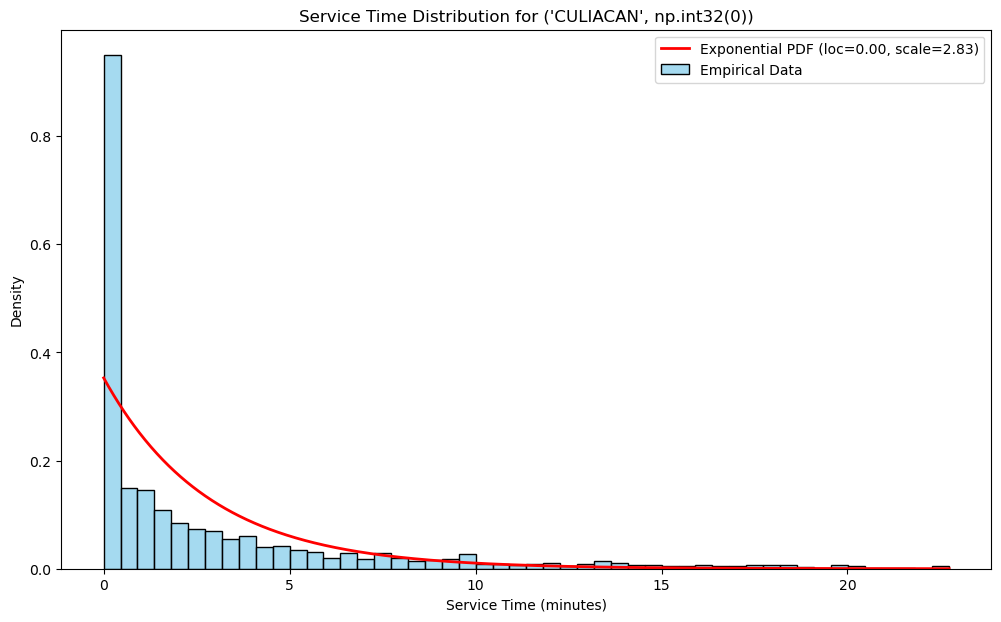

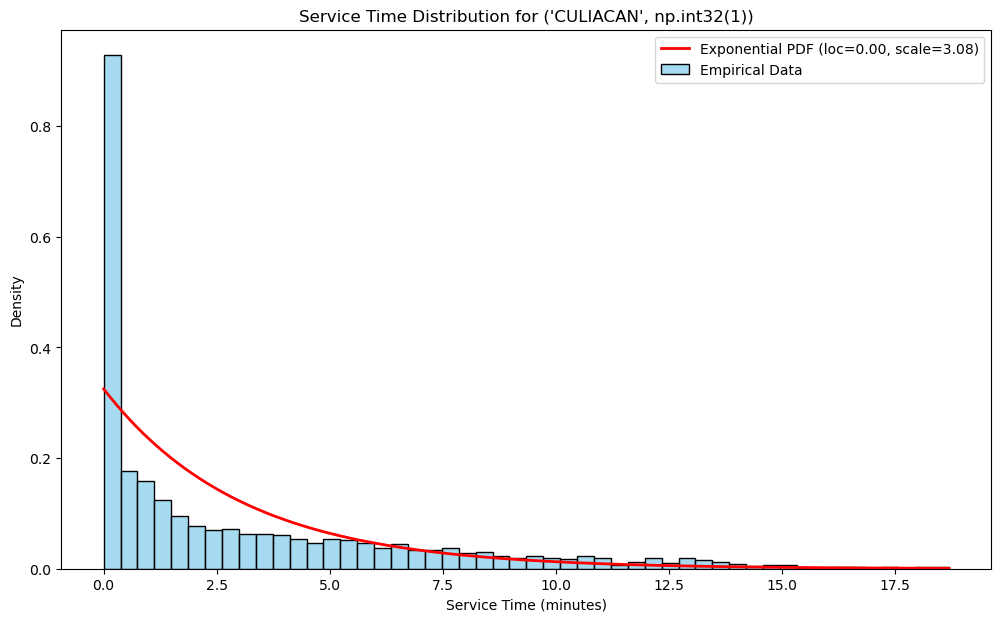

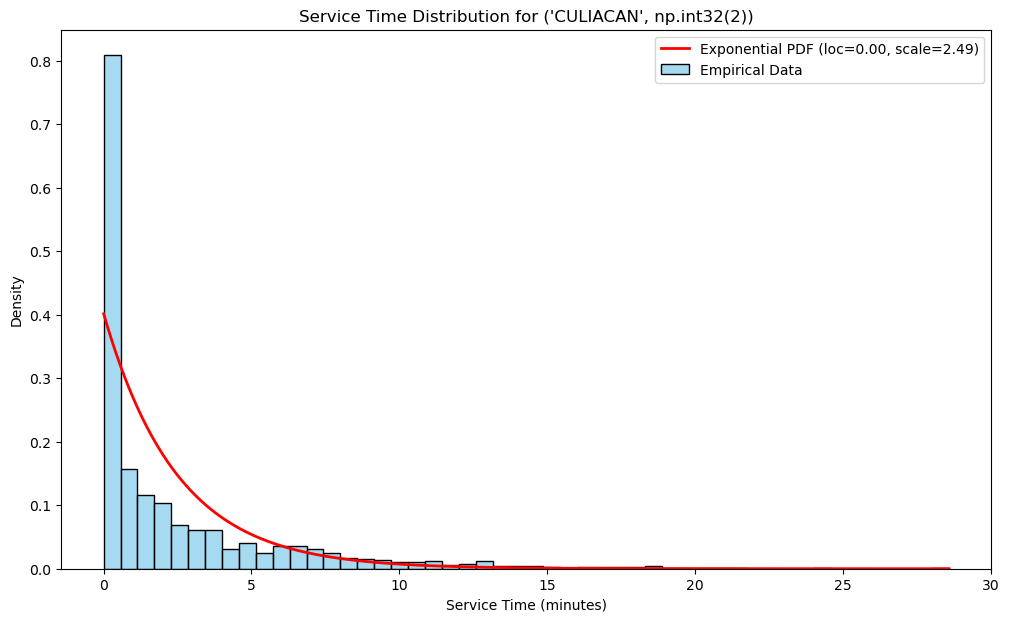

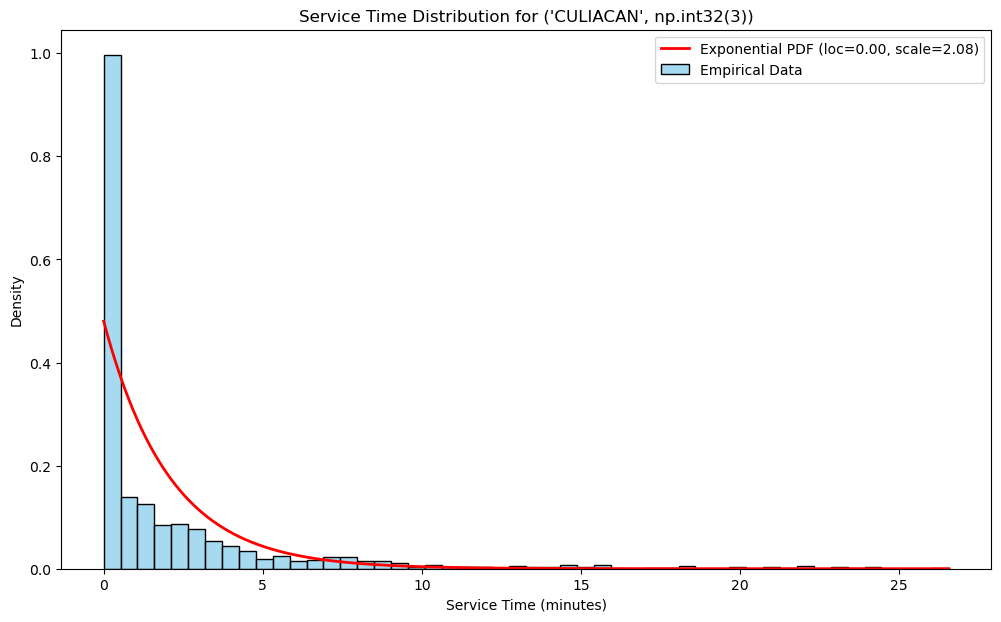

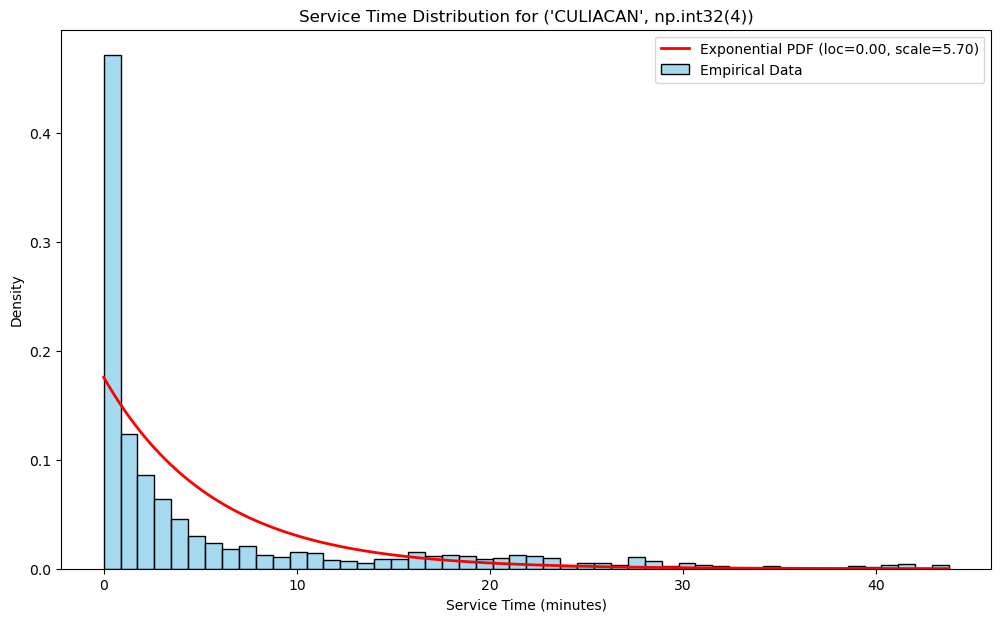

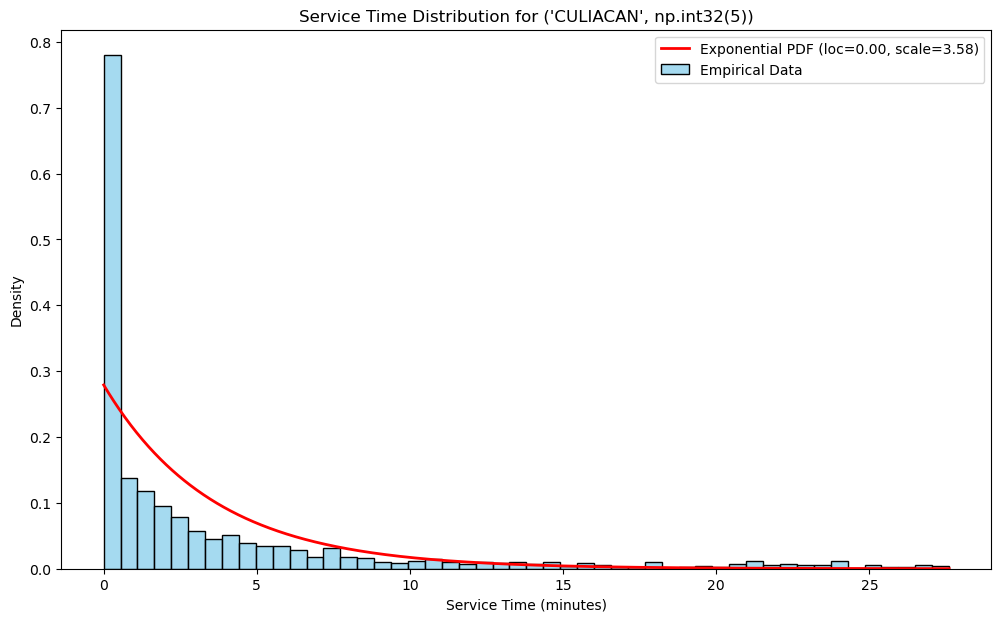

C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


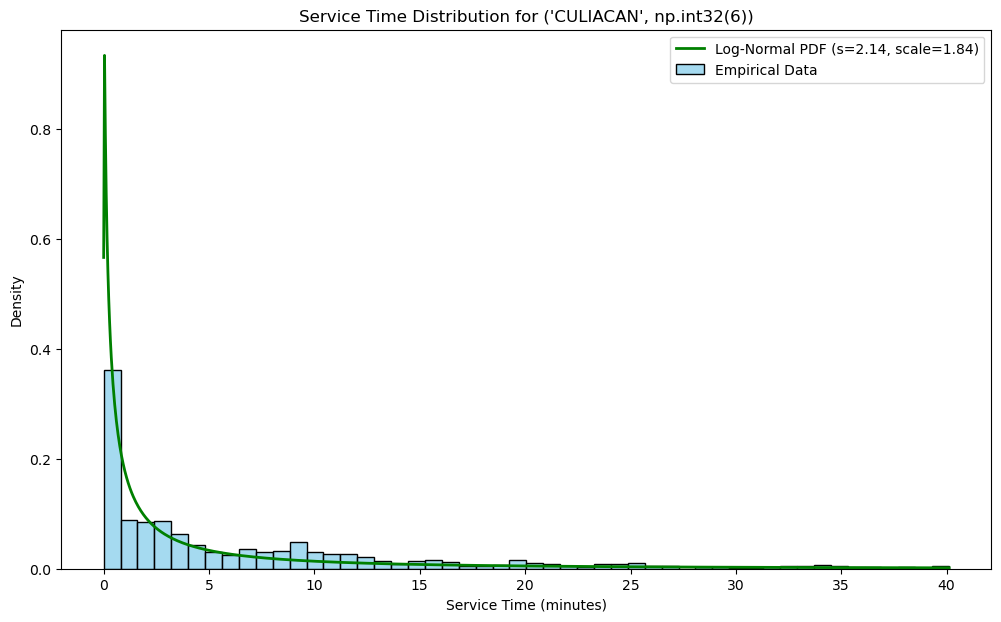

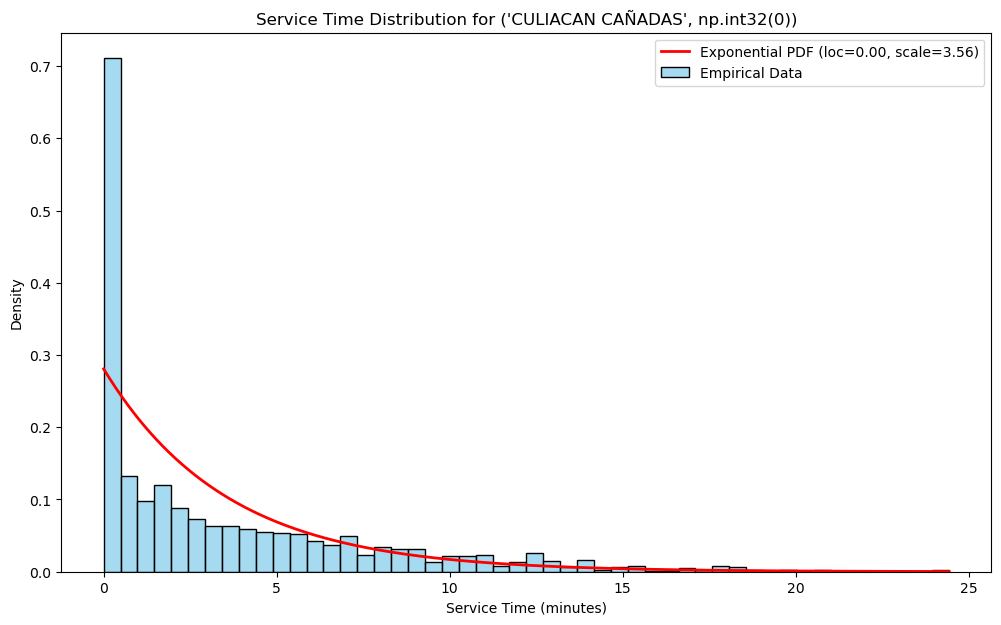

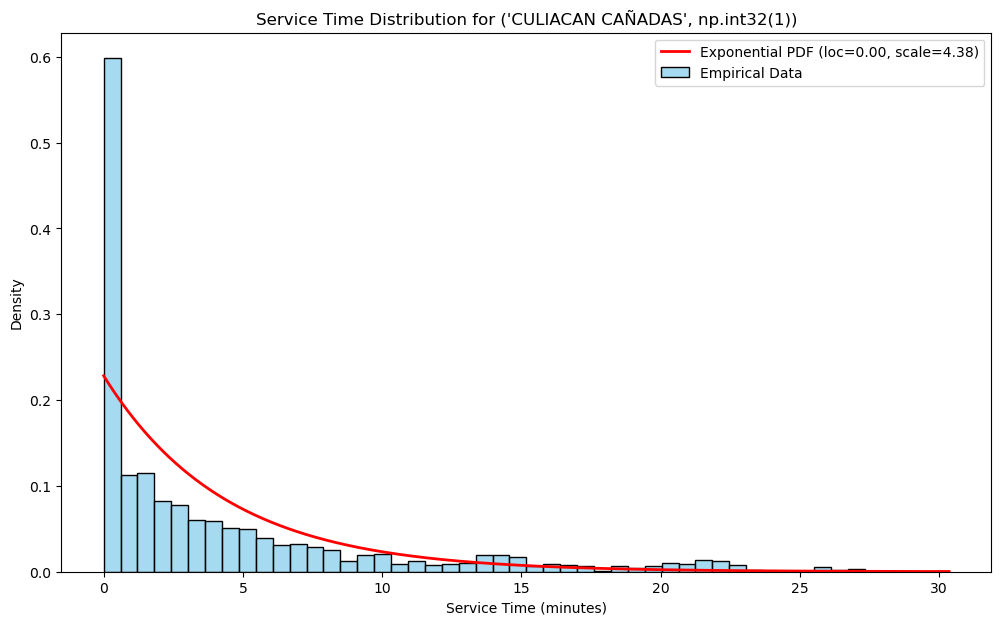

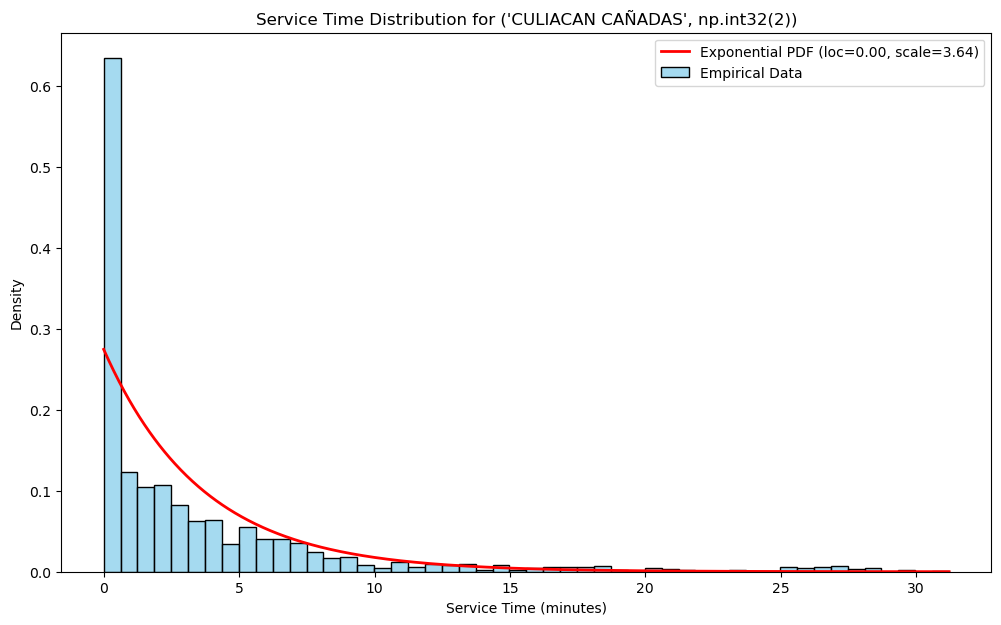

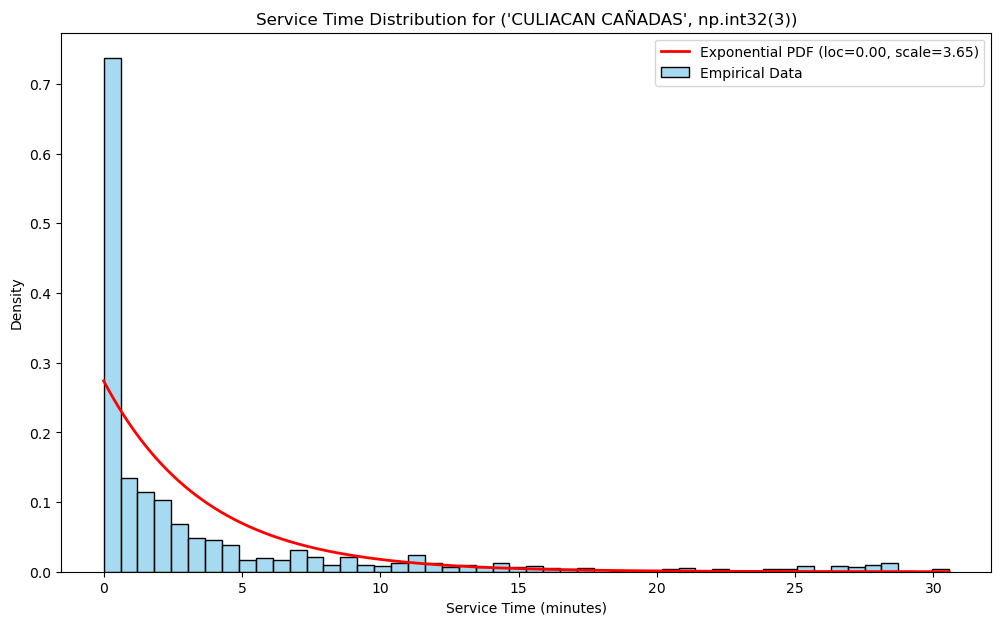

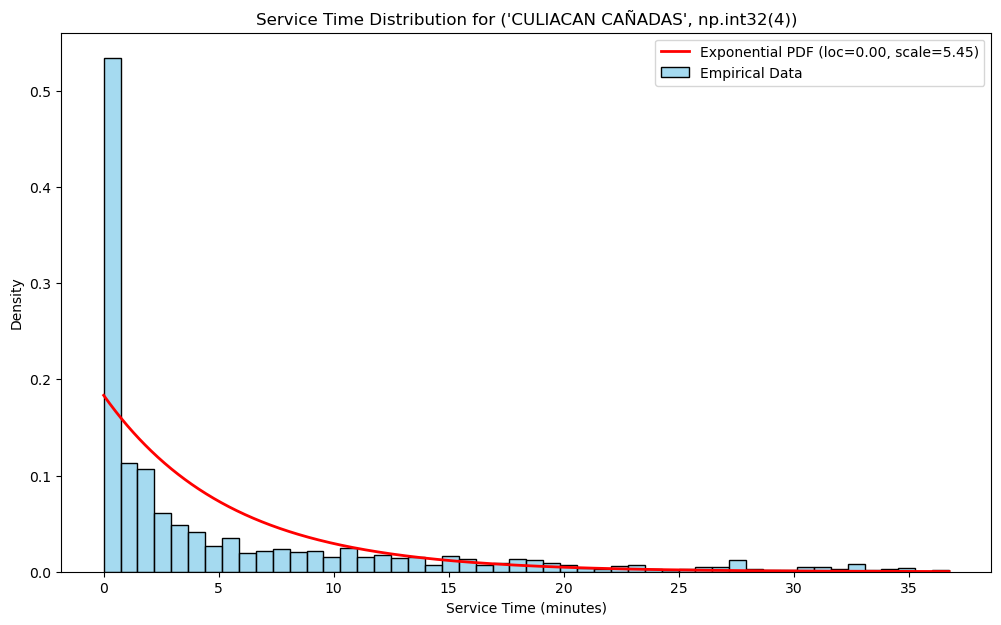

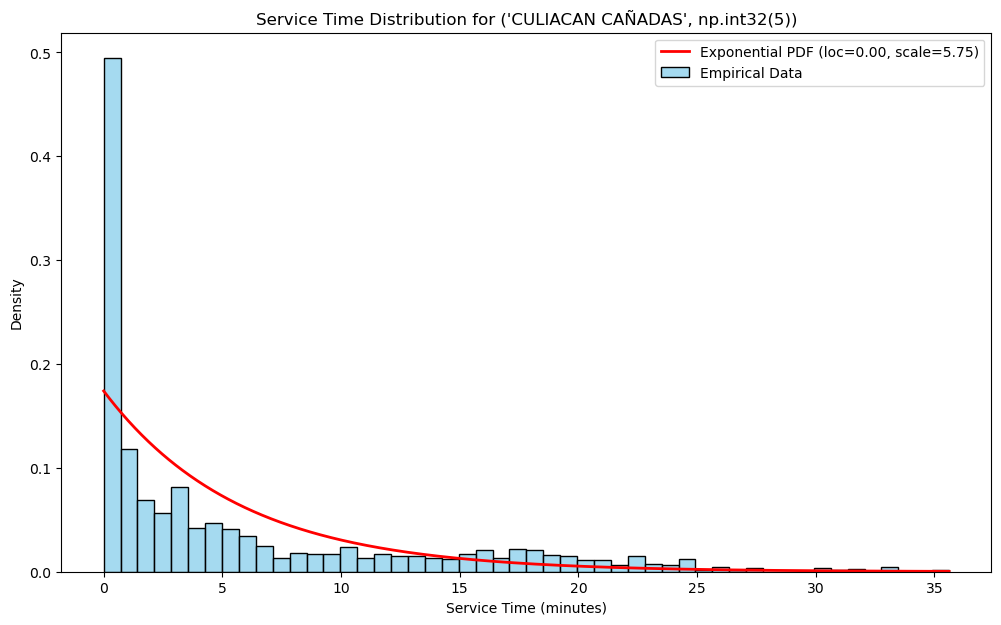

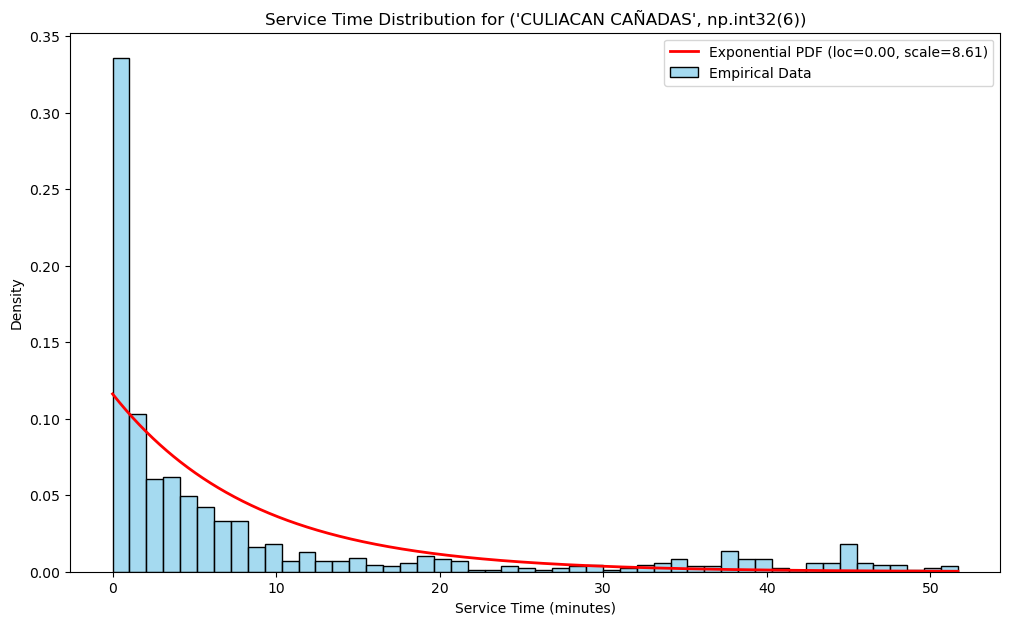

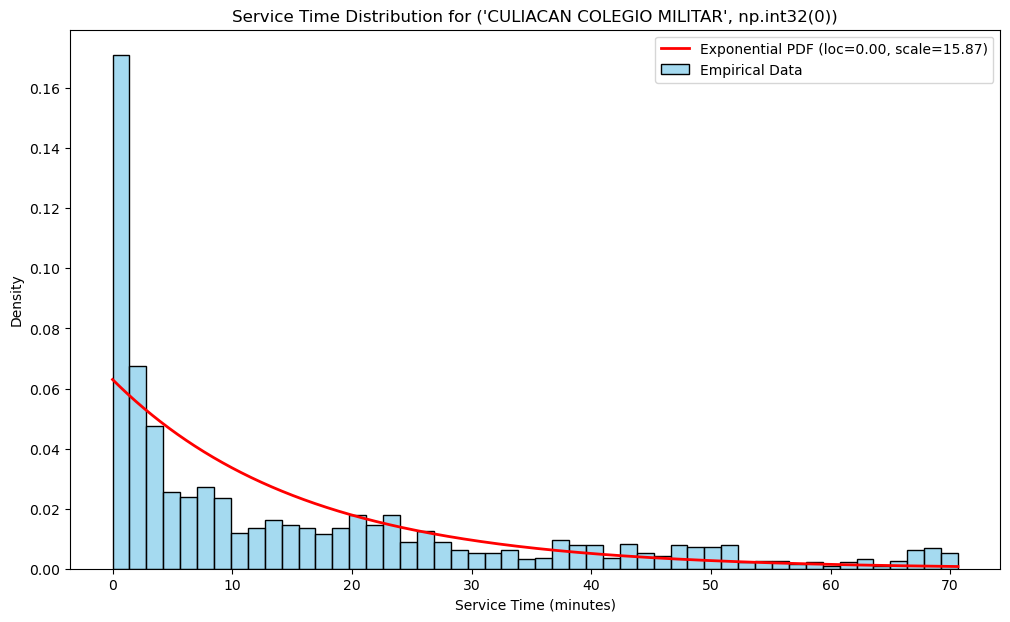

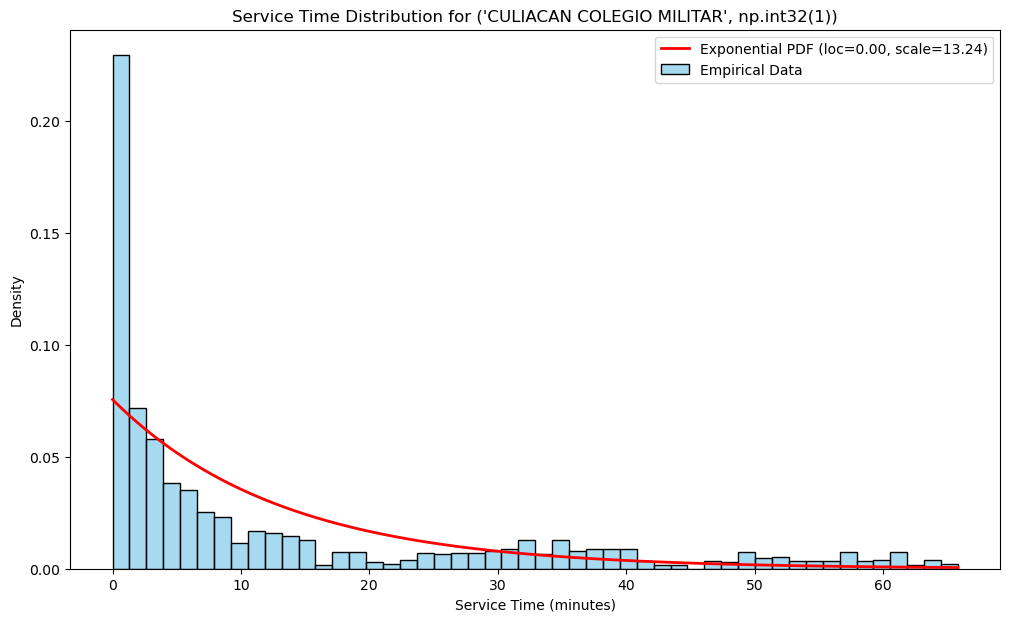

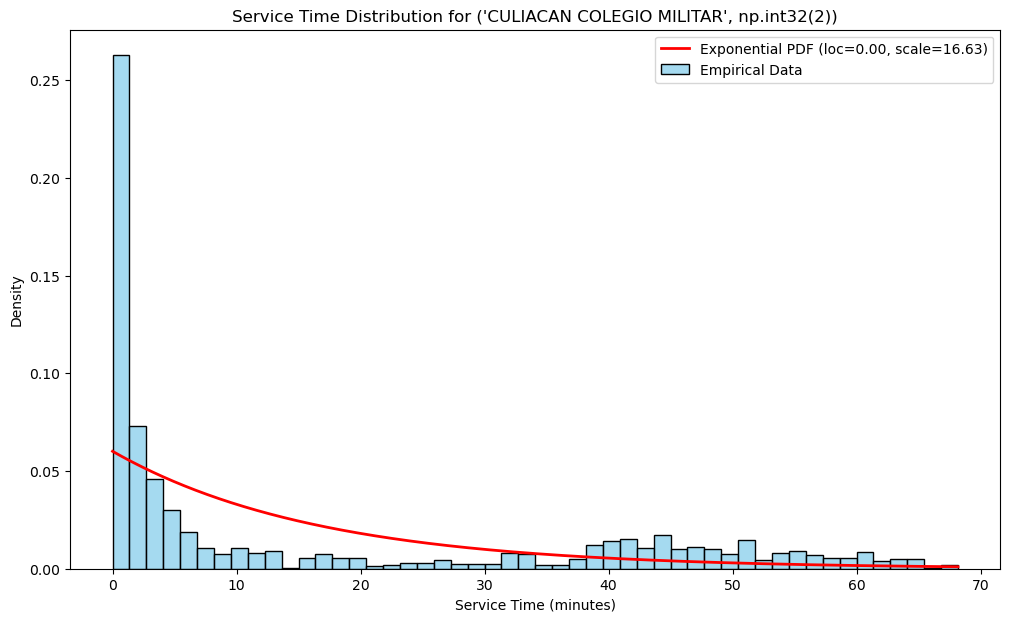

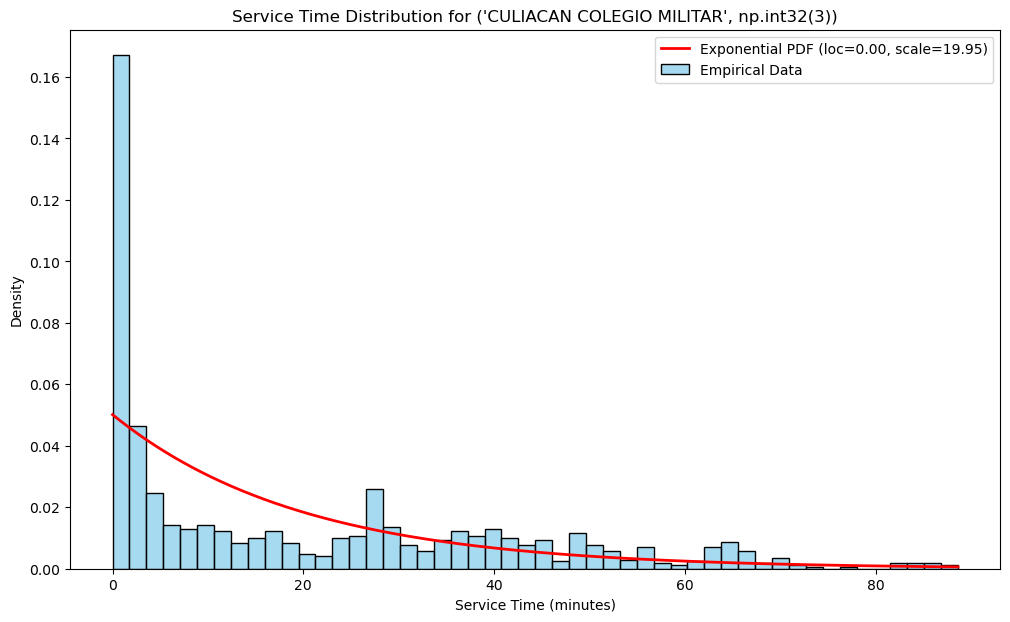

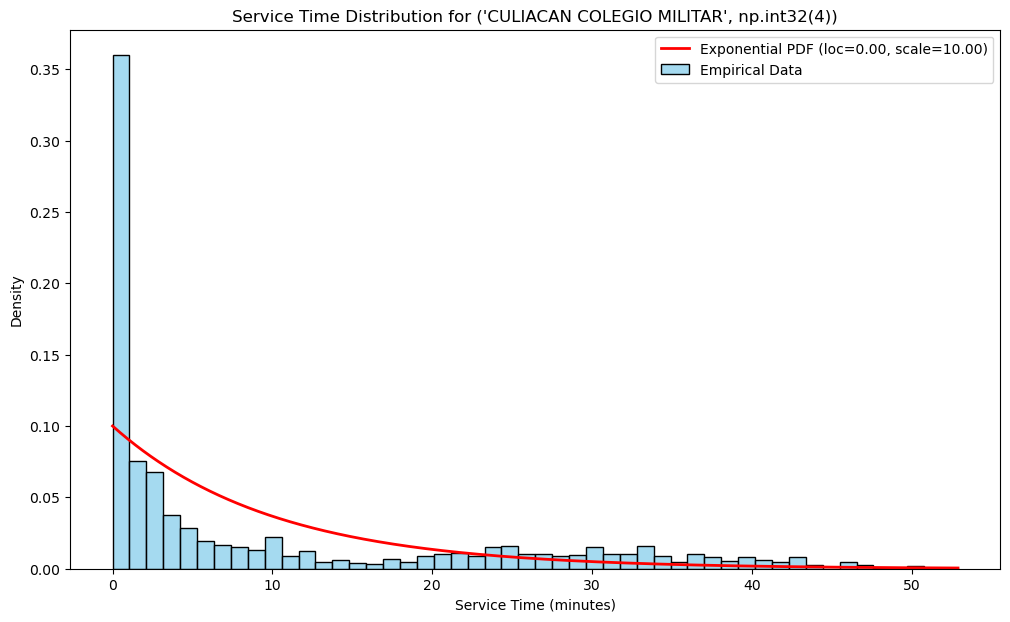

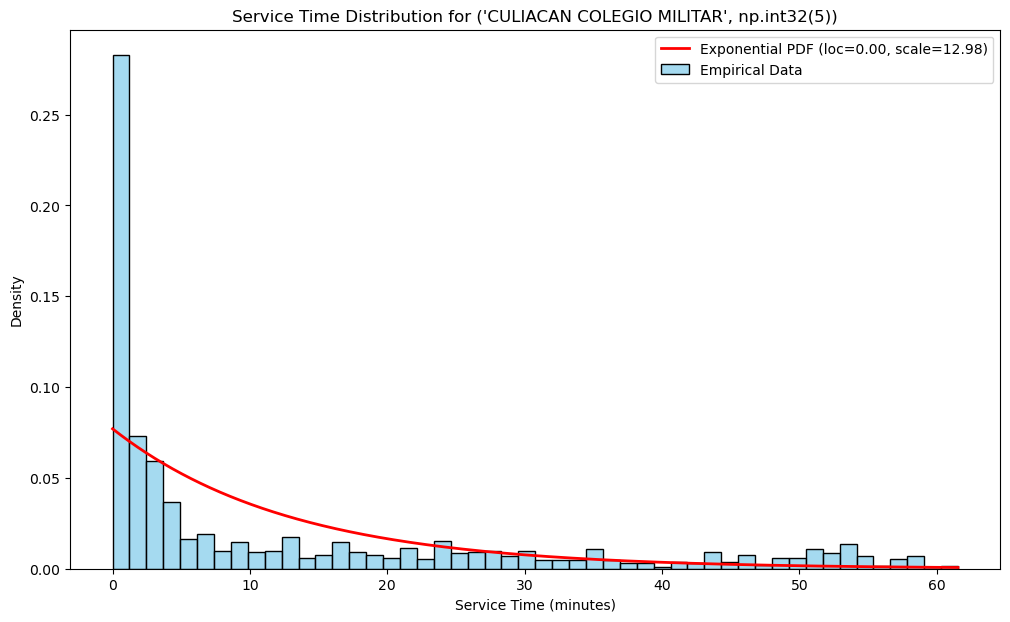

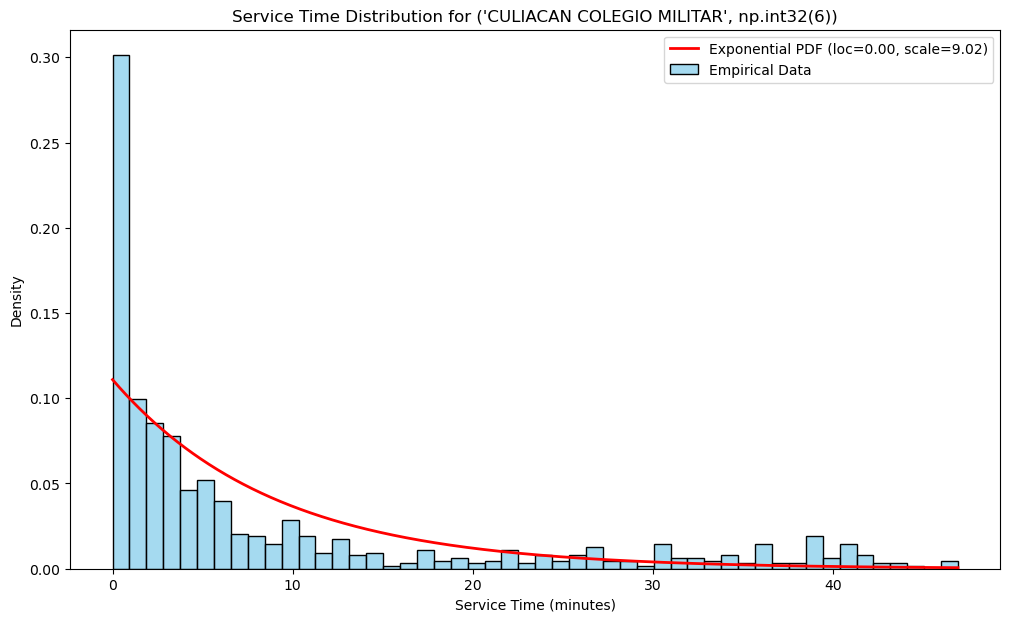

C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


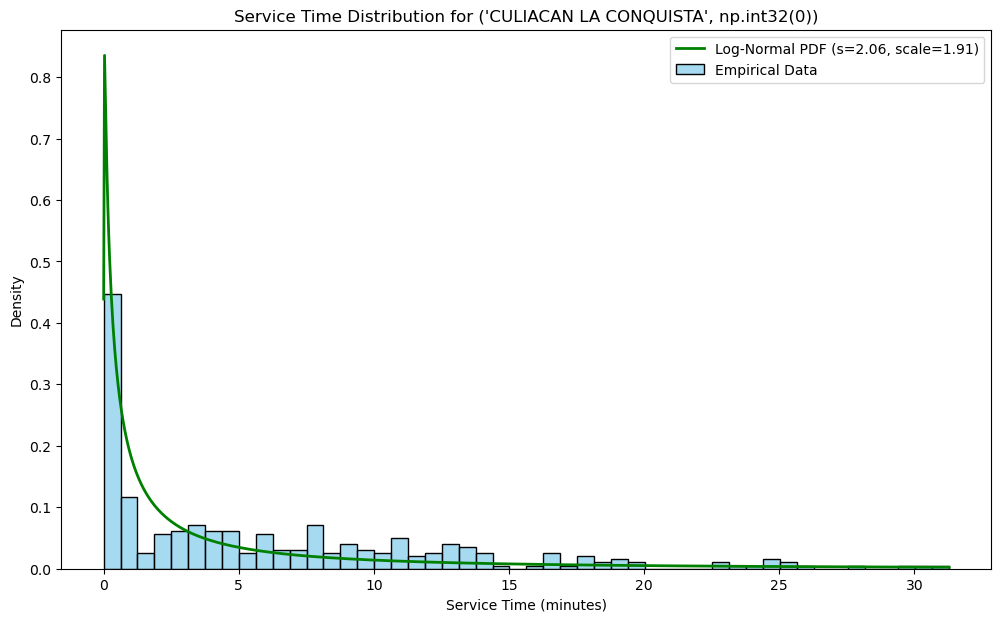

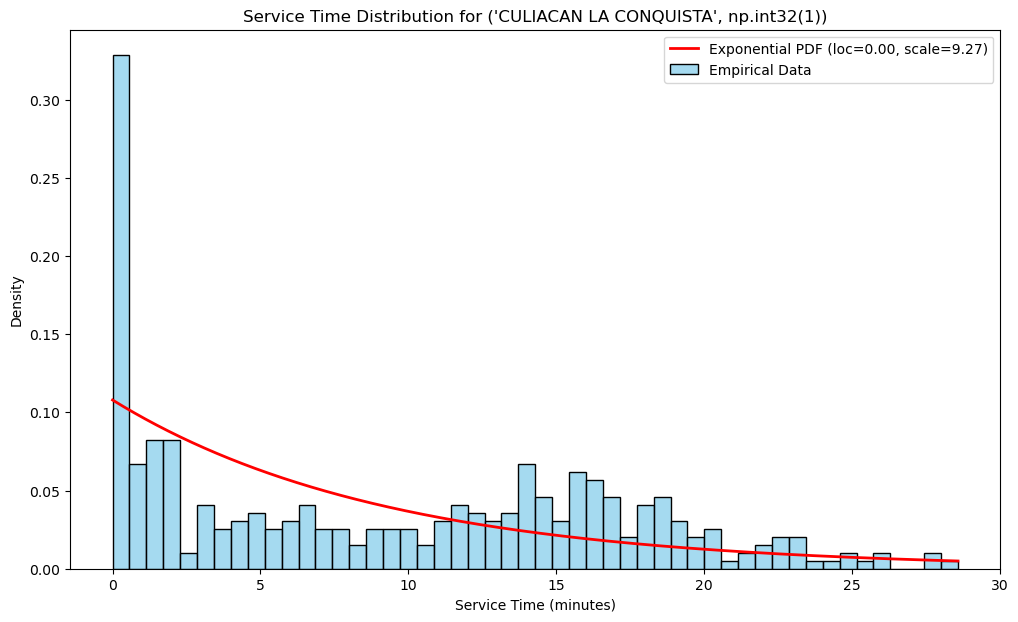

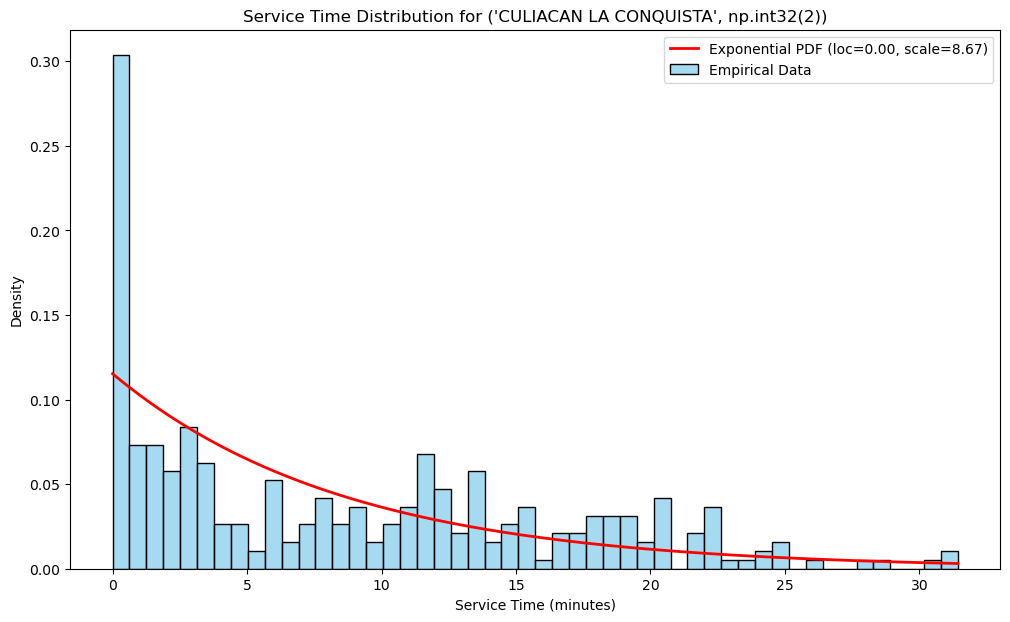

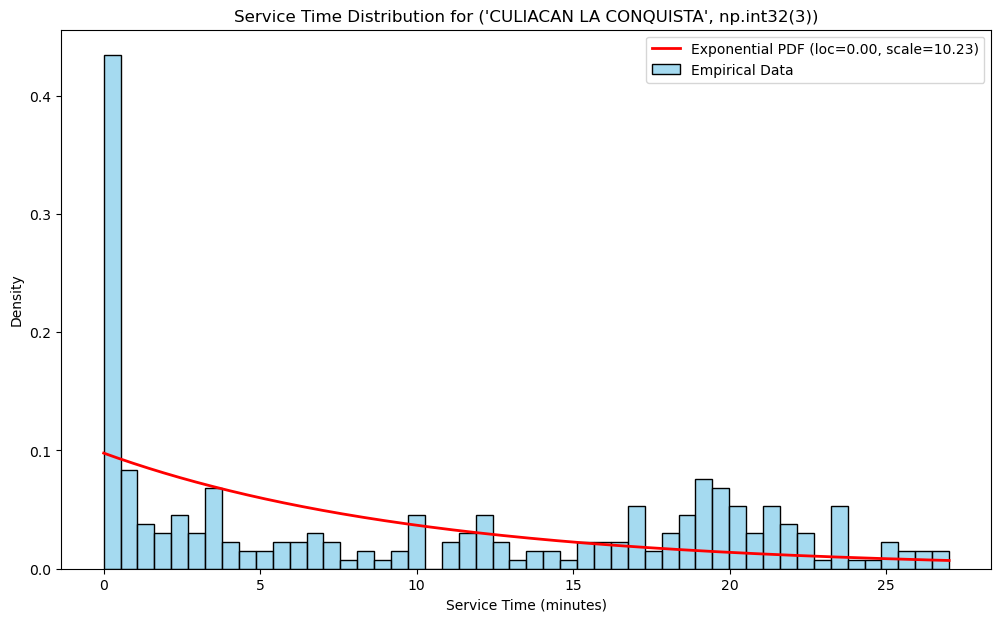

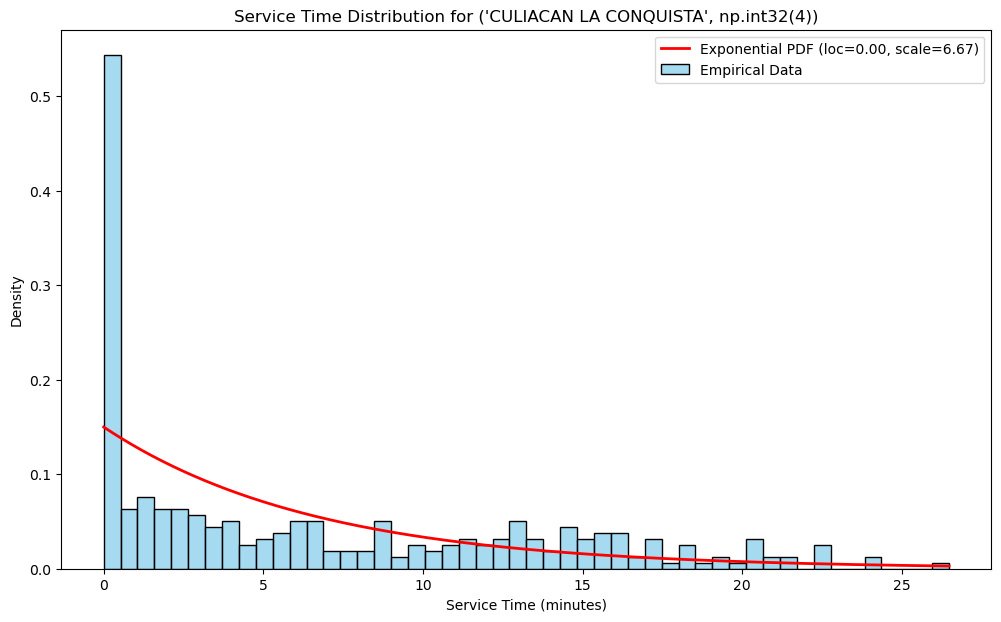

C:\Users\cumpl\miniconda3\envs\finalsem\Lib\site-packages\scipy\stats\_continuous_distns.py:6911: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


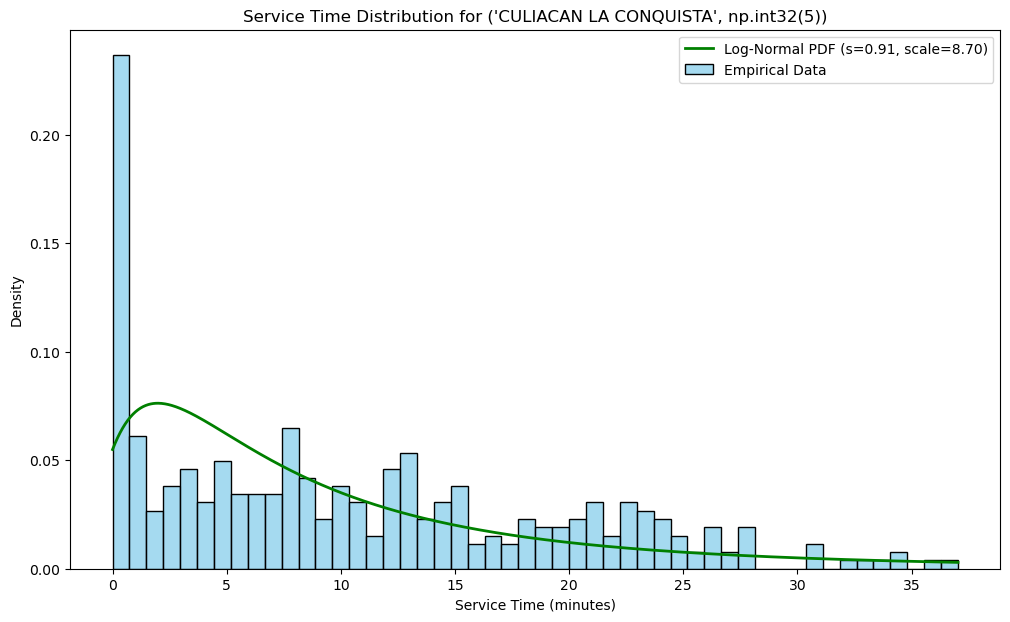

Sucursal                  DayOfWeek
CULIACAN                  0            None
                          1            None
                          2            None
                          3            None
                          4            None
                          5            None
                          6            None
CULIACAN CAÑADAS          0            None
                          1            None
                          2            None
                          3            None
                          4            None
                          5            None
                          6            None
CULIACAN COLEGIO MILITAR  0            None
                          1            None
                          2            None
                          3            None
                          4            None
                          5            None
                          6            None
CULIACAN LA CONQUISTA     0            N

In [38]:
clinics_df.dropna(
    subset=['WaitingTimeInLine_minutes']
).groupby(['Sucursal', 'DayOfWeek'])['WaitingTimeInLine_minutes'].apply(
    lambda x: show_pdf(x, chosen_distribution.loc[x.name])
)

## Arrival process deeper analysis

In [40]:
# work with a copy
apa_df = clinics_df.copy()

In [42]:
apa_df['TurnoInicioDateTime'].isna().sum()

np.int64(0)

In [43]:
# Sort the DataFrame by branch, and then by arrival time
apa_df.sort_values(by=['Sucursal', 'TurnoInicioDateTime'], inplace=True)

### Arrivals per day


Arrivals per day (sample):
   Sucursal    FechaID  Arrivals
0  CULIACAN 2024-03-01       576
1  CULIACAN 2024-03-02       466


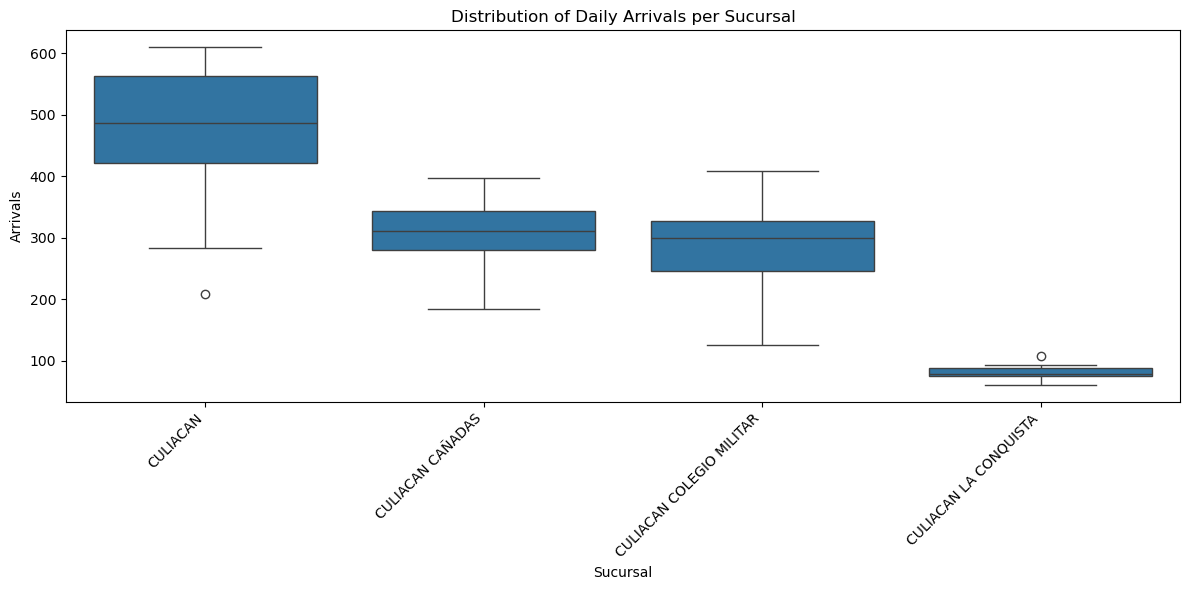

In [44]:
arrivals_per_day = apa_df.groupby(['Sucursal', 'FechaID']).size().reset_index(name='Arrivals')
print("\nArrivals per day (sample):")
print(arrivals_per_day.head(2))

plt.figure(figsize=(12, 6))
sns.boxplot(data=arrivals_per_day, x='Sucursal', y='Arrivals')
plt.title('Distribution of Daily Arrivals per Sucursal')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Arrivals by hour of day

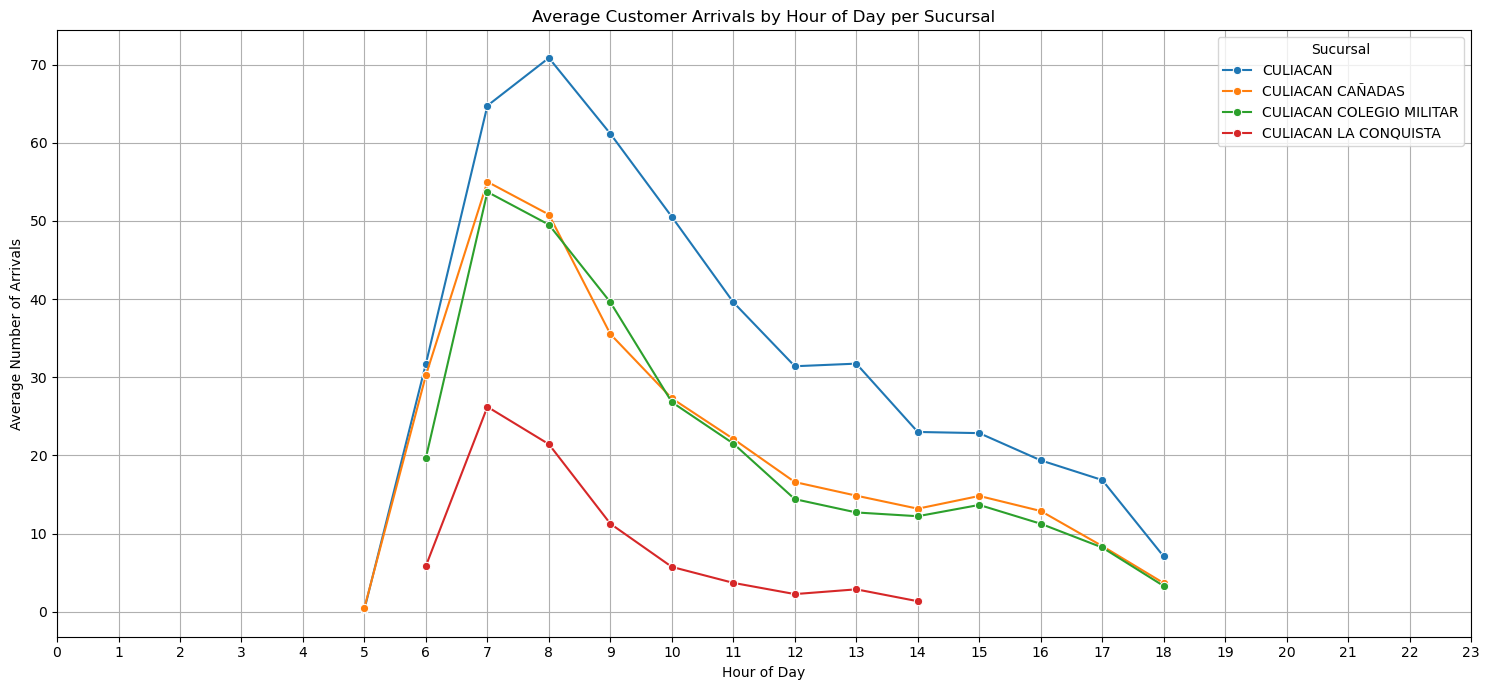

In [46]:
arrivals_by_hour = apa_df.groupby(['Sucursal', 'HourOfDay']).size().reset_index(name='Arrivals')

# To get average arrivals per hour over all days for each sucursal
num_days_per_sucursal = apa_df.groupby('Sucursal')['FechaID'].nunique()
avg_arrivals_by_hour = apa_df.groupby(['Sucursal', 'HourOfDay']).size().reset_index(name='TotalArrivals')
avg_arrivals_by_hour = avg_arrivals_by_hour.merge(num_days_per_sucursal.rename('NumDays'), on='Sucursal')
avg_arrivals_by_hour['AvgArrivalsPerHour'] = avg_arrivals_by_hour['TotalArrivals'] / avg_arrivals_by_hour['NumDays']


plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_arrivals_by_hour, x='HourOfDay', y='AvgArrivalsPerHour', hue='Sucursal', marker='o')
plt.title('Average Customer Arrivals by Hour of Day per Sucursal')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Arrivals')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Sucursal')
plt.tight_layout()
plt.show()

Observamos que la tasa de llegada no es homogénea a lo largo del día. Esto sugiere que una única tasa tasa de Poisson para todo el día no es appropiada. Quizá sea mejor considerar un proceso de Poisson no homogéneo (NHPP).

### Arrivals by day of week

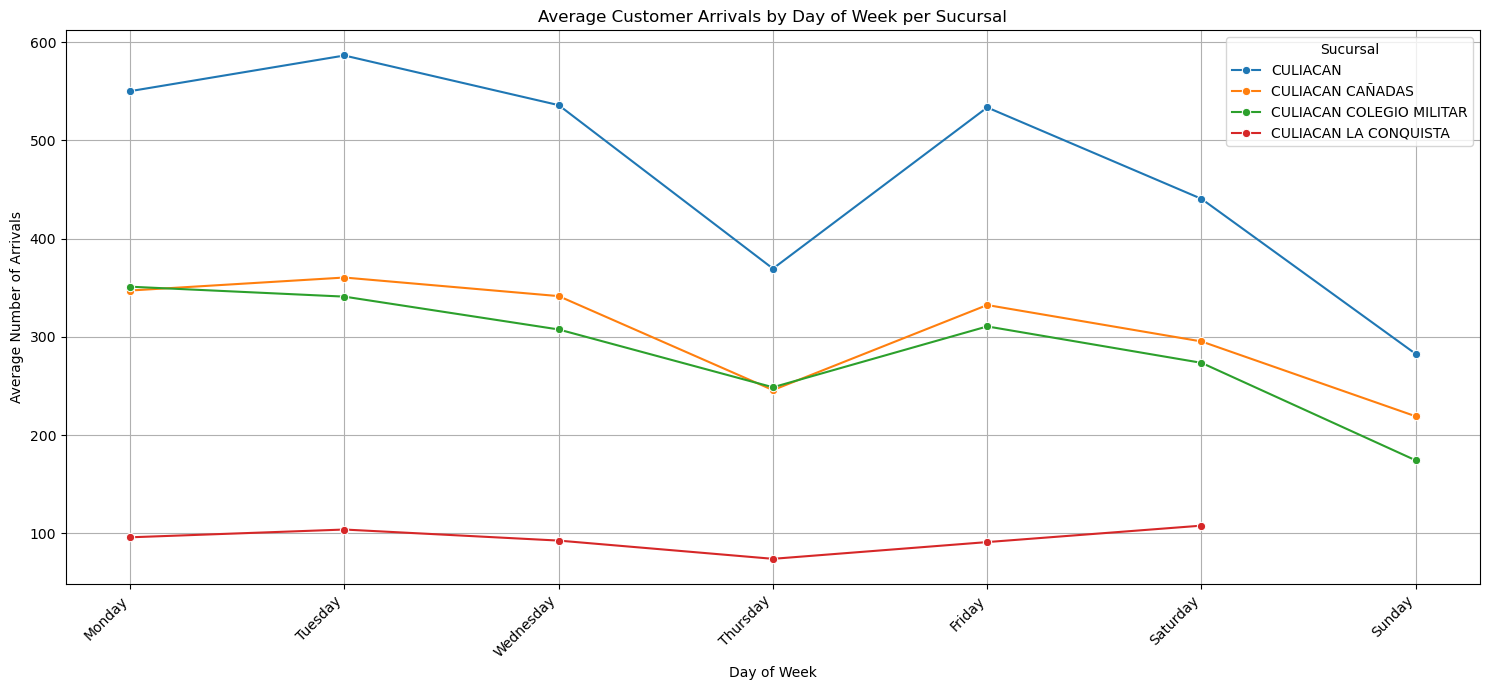

In [49]:
apa_df['DayOfWeekName'] = apa_df['TurnoInicioDateTime'].dt.day_name()
# Calculate average arrivals for each day of the week per sucursal
num_weeks_approx_per_sucursal = apa_df.groupby('Sucursal')['FechaID'].nunique() / 7
num_weeks_approx_per_sucursal[num_weeks_approx_per_sucursal < 1] = 1 # Avoid division by zero if less than a week of data

avg_arrivals_by_dow = apa_df.groupby(['Sucursal', 'DayOfWeekName']).size().reset_index(name='TotalArrivals')
avg_arrivals_by_dow = avg_arrivals_by_dow.merge(num_weeks_approx_per_sucursal.rename('NumWeeksApprox'), on='Sucursal')
avg_arrivals_by_dow['AvgArrivalsPerDayOfWeek'] = avg_arrivals_by_dow['TotalArrivals'] / avg_arrivals_by_dow['NumWeeksApprox']

days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
avg_arrivals_by_dow['DayOfWeekName'] = pd.Categorical(avg_arrivals_by_dow['DayOfWeekName'], categories=days_order, ordered=True)
avg_arrivals_by_dow.sort_values(by=['Sucursal', 'DayOfWeekName'], inplace=True)

plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_arrivals_by_dow, x='DayOfWeekName', y='AvgArrivalsPerDayOfWeek', hue='Sucursal', marker='o')
plt.title('Average Customer Arrivals by Day of Week per Sucursal')
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Arrivals')
plt.grid(True)
plt.legend(title='Sucursal')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Observamos picos y caídas en el promedio de llegadas a las sucursales dependiendo el día.

### Analyzing Inter-Arrival Times

In [51]:
# Calculate inter-arrival times in seconds
# .diff() calculates the difference with the previous row (which is the previous arrival due to sorting)
# The first arrival in each group will have a NaT (Not a Time)
apa_df['InterArrivalTimedelta'] = apa_df.groupby(['Sucursal', 'FechaID'])['TurnoInicioDateTime'].diff()

# Convert timedelta to a numerical unit (e.g., minutes)
apa_df['InterArrivalMinutes'] = apa_df['InterArrivalTimedelta'].dt.total_seconds() / 60.0

# Drop NaT results (first arrivals of each group) and non-positive times (if any data issues)
inter_arrival_times_df = apa_df.dropna(subset=['InterArrivalMinutes'])
inter_arrival_times_df = inter_arrival_times_df[inter_arrival_times_df['InterArrivalMinutes'] > 0]

print("\nSample Inter-Arrival Times:")
print(inter_arrival_times_df[['Sucursal', 'TurnoInicioDateTime', 'InterArrivalMinutes']].head())


Sample Inter-Arrival Times:
      Sucursal TurnoInicioDateTime  InterArrivalMinutes
4441  CULIACAN 2024-03-01 06:00:33             0.200000
2444  CULIACAN 2024-03-01 06:03:26             2.883333
4952  CULIACAN 2024-03-01 06:06:54             3.466667
2937  CULIACAN 2024-03-01 06:08:15             1.350000
1950  CULIACAN 2024-03-01 06:18:35            10.333333



Fitted Exponential Parameters for Inter-Arrival Times (CULIACAN):
Location: 0.0000, Scale (mean inter-arrival time): 1.4696 minutes
Estimated Arrival Rate (lambda): 0.6805 arrivals/minute


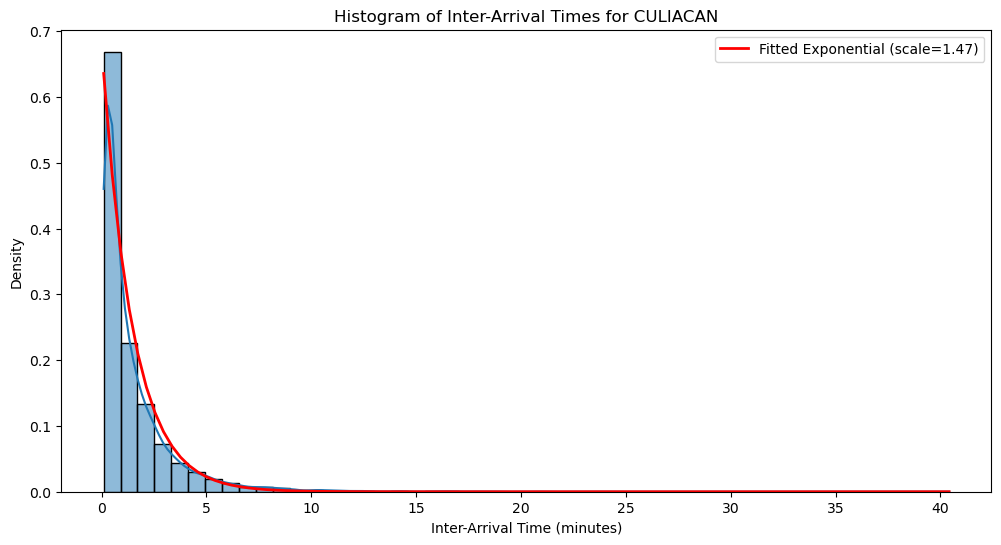

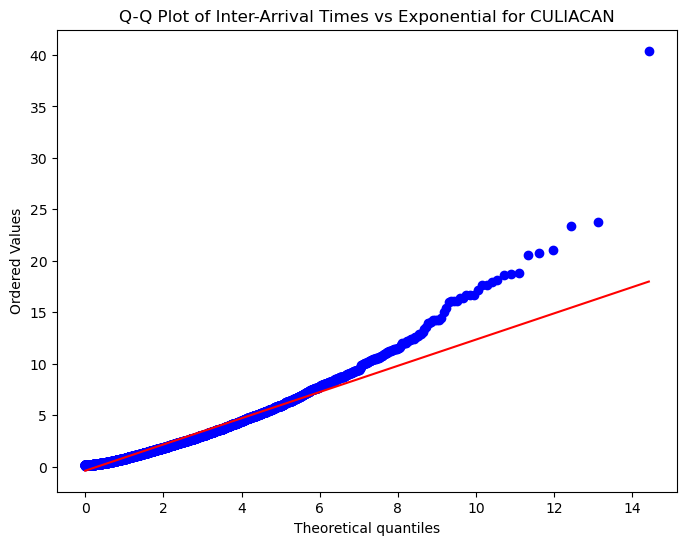

In [53]:
# Example: Analyze for one Sucursal. Loop or functionize for all.
target_sucursal = apa_df['Sucursal'].unique()[0] # Take the first branch as an example

# Optional: Filter for a specific period if rate is not constant
# For example, filter for work hours 9 AM to 5 PM
# inter_arrival_data_sucursal = inter_arrival_times_df[
#    (inter_arrival_times_df['Sucursal'] == target_sucursal) &
#    (inter_arrival_times_df['TurnoInicioDateTime'].dt.hour >= 9) &
#    (inter_arrival_times_df['TurnoInicioDateTime'].dt.hour < 17)
# ]['InterArrivalMinutes']

inter_arrival_data_sucursal = inter_arrival_times_df[inter_arrival_times_df['Sucursal'] == target_sucursal]['InterArrivalMinutes']

if not inter_arrival_data_sucursal.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(inter_arrival_data_sucursal, kde=True, bins=50, stat="density")
    plt.title(f'Histogram of Inter-Arrival Times for {target_sucursal}')
    plt.xlabel('Inter-Arrival Time (minutes)')
    plt.ylabel('Density')

    # Fit an exponential distribution
    # For exponential, loc is often 0. Scale = 1/lambda = mean.
    loc_exp, scale_exp = stats.expon.fit(inter_arrival_data_sucursal, floc=0) 
    print(f"\nFitted Exponential Parameters for Inter-Arrival Times ({target_sucursal}):")
    print(f"Location: {loc_exp:.4f}, Scale (mean inter-arrival time): {scale_exp:.4f} minutes")

    # Estimated arrival rate (lambda)
    estimated_lambda_from_interarrival = 1 / scale_exp
    print(f"Estimated Arrival Rate (lambda): {estimated_lambda_from_interarrival:.4f} arrivals/minute")

    # Overlay the fitted exponential PDF
    x_exp = np.linspace(inter_arrival_data_sucursal.min(), inter_arrival_data_sucursal.max(), 100)
    pdf_exp = stats.expon.pdf(x_exp, loc=loc_exp, scale=scale_exp)
    plt.plot(x_exp, pdf_exp, 'r-', lw=2, label=f'Fitted Exponential (scale={scale_exp:.2f})')
    plt.legend()
    plt.show()

    # Q-Q plot for exponential distribution
    plt.figure(figsize=(8, 6))
    stats.probplot(inter_arrival_data_sucursal, dist=stats.expon, sparams=(loc_exp, scale_exp), plot=plt)
    # Forcing loc for expon in probplot. For expon, loc is usually 0, and scale is the mean.
    # If using floc=0 in fit, sparams should reflect that. If fit returns (loc,scale),
    # and loc is 0, then sparams=(scale_exp) is often how it's passed if dist='expon' assumes loc=0.
    # Let's be explicit with the fitted parameters:
    # stats.probplot(inter_arrival_data_sucursal, dist=stats.expon(loc=loc_exp, scale=scale_exp), plot=plt) # More robust
    plt.title(f'Q-Q Plot of Inter-Arrival Times vs Exponential for {target_sucursal}')
    plt.show()
else:
    print(f"No inter-arrival data to plot for {target_sucursal} (or chosen period).")

### Analyzing Arrival Counts (to check for Poisson Distribution)

In [54]:
interval_minutes = 60 # Example: 1-hour intervals
# Create time bins for each Sucursal
# floor TurnoInicioDateTime to the start of the interval
apa_df['TimeBin'] = apa_df['TurnoInicioDateTime'].dt.floor(f'{interval_minutes}min')

arrival_counts_per_interval = apa_df.groupby(['Sucursal', 'TimeBin']).size().reset_index(name='ArrivalCount')

print("\nSample Arrival Counts per Interval:")
print(arrival_counts_per_interval.head())


Sample Arrival Counts per Interval:
   Sucursal             TimeBin  ArrivalCount
0  CULIACAN 2024-03-01 06:00:00            38
1  CULIACAN 2024-03-01 07:00:00            76
2  CULIACAN 2024-03-01 08:00:00            70
3  CULIACAN 2024-03-01 09:00:00            64
4  CULIACAN 2024-03-01 10:00:00            67



Arrival Counts Analysis for CULIACAN (Interval: 60 min):
Mean arrivals per interval: 38.9083
Variance of arrivals per interval: 431.4517
Note: Variance is noticeably greater than the mean, suggesting potential overdispersion (Poisson might not be a perfect fit).


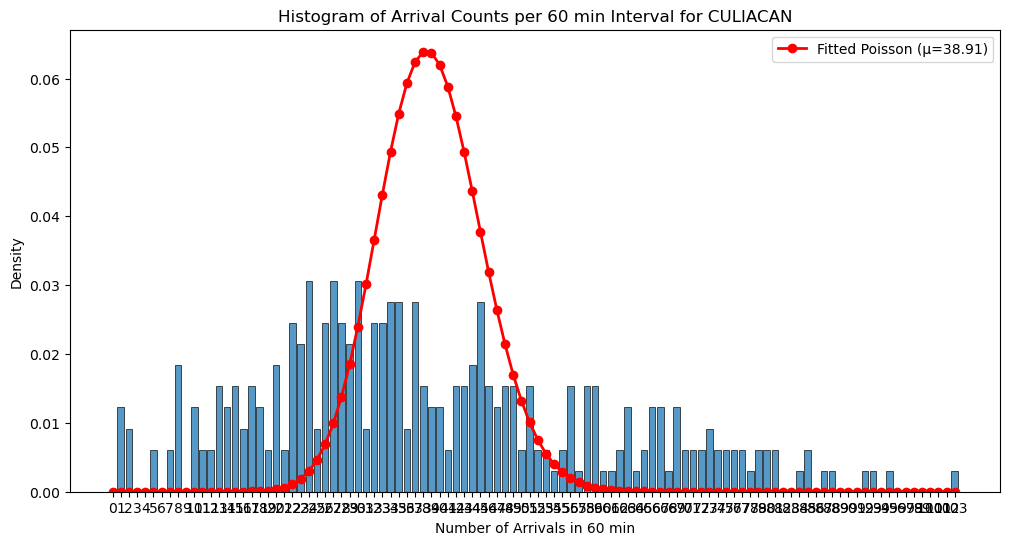

Chi-squared test for Poisson fit (CULIACAN):
Statistic: 102499337467614.7656, P-value: 0.0000
P-value < 0.05: The Poisson distribution may not be a good fit (reject null hypothesis).


In [55]:
# Example: Analyze for the same target_sucursal
# You might want to filter for specific hours of operation or periods of stable activity
# For example, only include bins within typical operating hours
# arrival_counts_sucursal = arrival_counts_per_interval[
#    (arrival_counts_per_interval['Sucursal'] == target_sucursal) &
#    (arrival_counts_per_interval['TimeBin'].dt.hour >= 9) &
#    (arrival_counts_per_interval['TimeBin'].dt.hour < 17) # Assuming 9-5
# ]['ArrivalCount']

arrival_counts_sucursal = arrival_counts_per_interval[
    arrival_counts_per_interval['Sucursal'] == target_sucursal
]['ArrivalCount']


if not arrival_counts_sucursal.empty:
    # For Poisson, mean should be approximately equal to variance
    mean_arrivals = arrival_counts_sucursal.mean()
    var_arrivals = arrival_counts_sucursal.var()
    print(f"\nArrival Counts Analysis for {target_sucursal} (Interval: {interval_minutes} min):")
    print(f"Mean arrivals per interval: {mean_arrivals:.4f}")
    print(f"Variance of arrivals per interval: {var_arrivals:.4f}")
    if var_arrivals > mean_arrivals * 1.15 : # Check for overdispersion (variance significantly > mean)
         print("Note: Variance is noticeably greater than the mean, suggesting potential overdispersion (Poisson might not be a perfect fit).")
    elif mean_arrivals > var_arrivals * 1.15: # Check for underdispersion
         print("Note: Mean is noticeably greater than the variance, suggesting potential underdispersion (Poisson might not be a perfect fit).")


    plt.figure(figsize=(12, 6))
    # Calculate frequencies for histogram
    max_count = arrival_counts_sucursal.max()
    bins = np.arange(-0.5, max_count + 1.5, 1) # Centered bins for discrete counts
    sns.histplot(arrival_counts_sucursal, bins=bins, stat="density", discrete=True, shrink=0.8)
    plt.title(f'Histogram of Arrival Counts per {interval_minutes} min Interval for {target_sucursal}')
    plt.xlabel(f'Number of Arrivals in {interval_minutes} min')
    plt.ylabel('Density')

    # Fit a Poisson distribution (mu = mean_arrivals)
    # For Poisson, the parameter mu (lambda in some texts) is the mean.
    mu_poisson = mean_arrivals 

    # Overlay the fitted Poisson PMF
    k_poisson = np.arange(0, max_count + 1)
    pmf_poisson = stats.poisson.pmf(k_poisson, mu=mu_poisson)
    plt.plot(k_poisson, pmf_poisson, 'ro-', lw=2, label=f'Fitted Poisson (μ={mu_poisson:.2f})')
    plt.legend()
    plt.xticks(k_poisson)
    plt.show()

    # Goodness-of-fit (Chi-squared test for Poisson)
    # Observed frequencies
    observed_frequencies = arrival_counts_sucursal.value_counts().sort_index()
    # Expected frequencies
    # Need to ensure k_poisson covers the range of observed_frequencies.index
    k_values_for_expected = np.arange(0, observed_frequencies.index.max() + 1)
    expected_pmf = stats.poisson.pmf(k_values_for_expected, mu=mu_poisson)
    expected_frequencies = expected_pmf * len(arrival_counts_sucursal)

    # Combine categories if expected frequencies are too low (e.g., < 5) - simplified here
    # For a proper chi-squared test, you'd need to handle binning carefully.
    # Scipy's chisquare requires observed and expected for the same categories.

    # Align observed and expected
    expected_series = pd.Series(expected_frequencies, index=k_values_for_expected)
    # Only compare where we have observed data, or handle bins carefully
    # This is a simplified alignment
    common_index = observed_frequencies.index.intersection(expected_series.index)
    obs_aligned = observed_frequencies[common_index]
    exp_aligned = expected_series[common_index]

    # If last category of expected is "rest", sum tails
    if len(expected_series) > len(common_index): # if expected has more bins (e.g. for higher k not observed)
        tail_exp_sum = expected_series[~expected_series.index.isin(common_index)].sum()
        if common_index.max() == obs_aligned.index.max() and tail_exp_sum > 0: # if last bins align
            exp_aligned.iloc[-1] += tail_exp_sum # Add tail to last common bin


    # Ensure no expected frequencies are zero to avoid division by zero in chi-square formula if calculated manually.
    # stats.chisquare handles this if f_exp contains zeros.
    # Filter out where expected is very low or zero if necessary, or combine bins.
    # For simplicity here, we proceed, but in practice, binning is key for chi-square.
    if len(obs_aligned) > 1 and len(exp_aligned) > 1 and obs_aligned.sum() > 0 and exp_aligned.sum() > 0:
        # Degrees of freedom: number of categories - 1 - number of estimated parameters (1 for mu)
        ddof = 1 
        try:
             chi2_stat, p_value_chi2 = stats.chisquare(f_obs=obs_aligned, f_exp=exp_aligned, ddof=ddof)
             print(f"Chi-squared test for Poisson fit ({target_sucursal}):")
             print(f"Statistic: {chi2_stat:.4f}, P-value: {p_value_chi2:.4f}")
             if p_value_chi2 < 0.05:
                 print("P-value < 0.05: The Poisson distribution may not be a good fit (reject null hypothesis).")
             else:
                 print("P-value >= 0.05: The Poisson distribution could be an adequate fit (cannot reject null hypothesis).")
        except ValueError as e:
             print(f"Could not perform Chi-squared test: {e}. Often due to low expected frequencies or mismatched array lengths after filtering.")
    else:
        print("Not enough distinct categories or data for Chi-squared test after alignment.")

else:
    print(f"No arrival count data to plot for {target_sucursal} (or chosen period).")

Esto confirma nuestra hipótesis sobre que modelar las llegadas como un proceso de Poisson único no se apega a la realidad. Ahora nos parece mejor idea explorar un NHPP.

Como el problema implica hacer una distición entre clientes según su tipo de turno (N, P, C, F, aunque en realidad solo vamos a distinguir entre [(N, C, F), (P)]), vamos a utilizar modelos distintos para cada grupo. ¿Por qué? Para que nuestro sistema incluya información sobre la posible llegada de clientes P al calcular la nueva posición en la cola de clientes con del grupo (N, C, F).